In [318]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from time import sleep
import seaborn as sns
from matplotlib.colors import ListedColormap
import itertools
import joblib
import concurrent.futures
import numba
from numba import cuda
import os


## GridWorld Functions

In [3]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.maxsteps = 100

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
        self.done = False
        self.steps = 0
        return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break
        self.steps +=1
        
       
        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_state = np.where(arr == np.amax(arr))
          next_state = next_state[0][0]
    
        
        if self.steps >= self.maxsteps or next_state in self.goal_states_seq:
            self.done = True

        return next_state, self.R[next_state],self.done


In [673]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0)
env = gw.create_gridworld()

## Visualizing Grid world

In [675]:
def visualize_grid(grid, obstructions,bad_states,restart_states,goal_states,outside,start_state,ax = None):

    grid[tuple(zip(*obstructions))] = 4  # Obstructions - orange
    grid[tuple(zip(*bad_states))] = 3  # Bad States   -   red
    grid[tuple(zip(*restart_states))] = 2  # Restart States - green
    grid[tuple(zip(*goal_states))] = 1  # Goal States - blue
    grid[tuple(zip(*outside))] = 6
    grid[tuple(zip(*start_state))] = 5  # Start State - yellow

    # Define a custom colormap
    cmap = ListedColormap(['white', 'blue', 'green', 'red', 'orange',"yellow", 'grey'])
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    plt.clf()

    ax.pcolor((grid), cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().invert_yaxis()


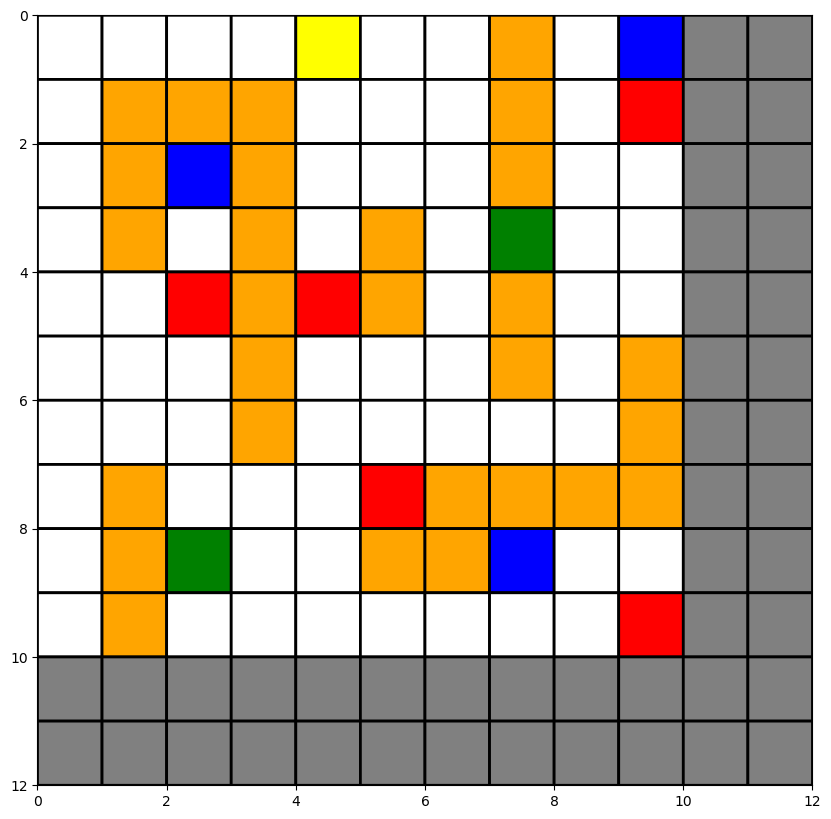

In [676]:
dummy_grid = np.zeros((num_rows+2, num_cols+2))

outside = np.array([(i, j) for i in range(num_rows + 2) for j in range(num_cols + 2) if i >= num_rows or j >= num_cols])


# Visualize the grid
plt.figure(figsize=(num_cols, num_rows))

visualize_grid(dummy_grid, obstructions,bad_states,restart_states,goal_states,outside,start_state,plt)
plt.show()


In [677]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


In [678]:
env.P[0,:,0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Grid world

### Tasks:

- Implement SARSA and Q-Learning algorithms.

## Create Test Environemnt

In [679]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw_1 = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw_1.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw_1.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw_1.add_transition_probability(p_good_transition=1,
                              bias=0)
env_1 = gw_1.create_gridworld()

## Visualization Code

In [685]:
def visulaize_Q_optimal(Q ,filename=None, message =""):
    
    plt.figure(figsize=(num_rows,num_cols))

    plt.title("Grid with Q values and optimal actions for the best policy")
    policy = np.zeros((num_rows,num_cols,4))
    
    for i in range(num_cols*num_rows):
        ind = seq_to_col_row(i,num_cols).flatten()
        policy[ind[0]][ind[1]] = Q[i]
    
    plt.pcolor((policy.max(-1)), edgecolors='k', linewidths=2,cmap ="bwr")
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy= policy.argmax(-1)
    policy[tuple(zip(*obstructions))] =-1
    policyx = np.vectorize(x_direct)((policy))
    policyy = np.vectorize(y_direct)((policy))
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='black')
    plt.gca().invert_yaxis()
    if filename is not None:
        plt.savefig(filename, dpi=260)

    plt.show()


def visualize_steps_heatmap(step_visits,filename=None):
    
    cmap = plt.cm.seismic
    plt.figure(figsize=(num_rows,num_cols))

    plt.pcolor((step_visits), cmap=cmap, edgecolors='k', linewidths=2)
    plt.colorbar()

    plt.xlim([0, num_cols])
    plt.ylim([0, num_rows])

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()

    plt.title('Grid with state visit counts')
    if filename is not None:
        plt.savefig(filename, dpi=260)

    plt.show()

def visualize_rewards(episode_rewards,filename=None):
    episodes = len(episode_rewards)
    
    # Calculate mean and standard deviation
    std_rewards = np.std(episode_rewards)
    plt.figure(figsize=(num_rows,num_cols))
    
    # Plot reward curves
    plt.plot(range(1, episodes + 1), episode_rewards, label='Mean Rewards', color='blue')
    plt.fill_between(range(1, episodes + 1), episode_rewards - std_rewards, episode_rewards + std_rewards, color='blue', alpha=0.3)


    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Reward Curves')
    plt.savefig(filename, dpi=260)

    plt.show()

def visualize_steps(steps_to_completion,filename):
    episodes = len(steps_to_completion)
      
    std_steps = np.std(steps_to_completion)
    plt.figure(figsize=(num_rows,num_cols))

    # Plot steps to completion
    plt.plot(range(1, episodes + 1), steps_to_completion, label='Mean Steps to Completion', color='green')
    plt.fill_between(range(1, episodes + 1), steps_to_completion - std_steps, steps_to_completion + std_steps, color='green', alpha=0.3)

    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Steps to Completion')
    plt.savefig(filename, dpi=260)
    plt.show()

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

In [686]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)
num_actions = (env_1.num_actions)
# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if rg.rand() < epsilon or not Q[state].any(): 
        return rg.choice(num_actions)
    else:
        return np.argmax(Q[state])

# Softmax
def choose_action_softmax(Q, state, tau,rg=rg):
    return rg.choice(num_actions,p=softmax(Q[state]/tau))

In [687]:
# initialize Q-value
Q = np.zeros((env_1.num_states, env_1.num_actions))

alpha0 = 0.3
gamma = 0.9
episodes = 10000
epsilon0 = 0.1
tau0 = 0.3

## SARSA Algorithm

In [688]:
print_freq = 500

def sarsa(env, Q, gamma = 0.9, alpha=0.4 ,plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visits =  np.zeros((episodes,env.num_rows,num_cols))
    if plot_heat:
        clear_output(wait=True)
        visulaize_Q_optimal(Q)
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        state_nseq = seq_to_col_row(state,num_cols).flatten()
        state_visits[ep][state_nseq[0]][[state_nseq[1]]] +=1
        while not done:
            state_next, reward, done = env.step(state,action)
            action_next = choose_action(Q, state_next)
            
            Q[state,action] += alpha*(reward + gamma*Q[state_next,action_next] - Q[state,action])                       
            tot_reward += reward
            steps += 1
            
            state_nseq = seq_to_col_row(state_next,num_cols).flatten()
            state_visits[ep][state_nseq[0]][[state_nseq[1]]] +=1
             
            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            visulaize_Q_optimal(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
                
    return Q, episode_rewards, steps_to_completion,state_visits

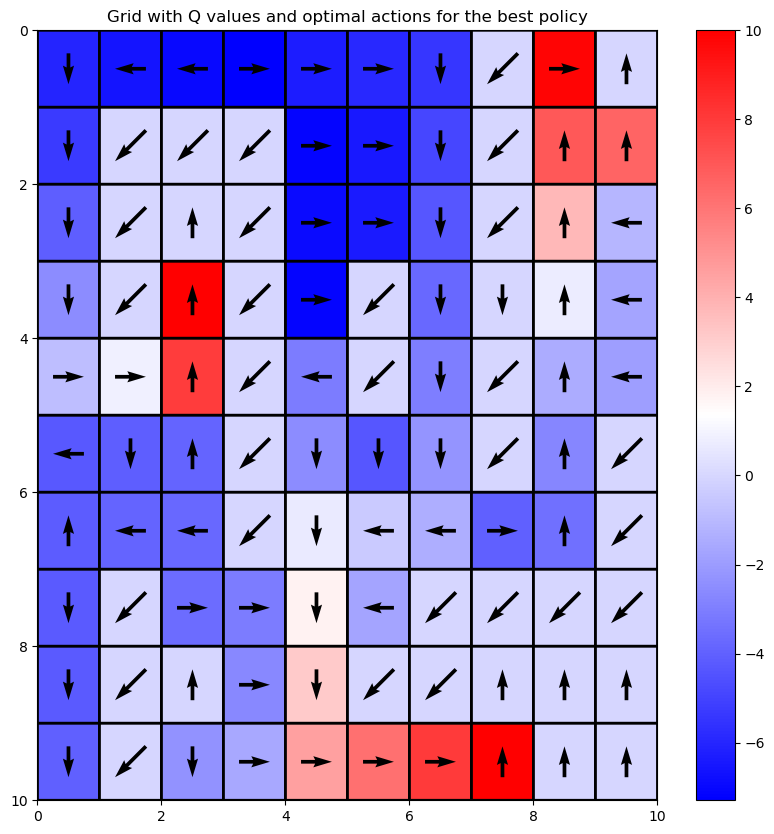

100%|██████████| 10000/10000 [00:11<00:00, 902.91it/s]


In [689]:
Q = np.zeros((env_1.num_states, env_1.num_actions))

Q, rewards, steps,steps_visted = sarsa(env_1, Q, gamma = gamma,alpha = alpha0,plot_heat =True, choose_action=lambda Q, state: choose_action_softmax(Q, state, epsilon0,rg))

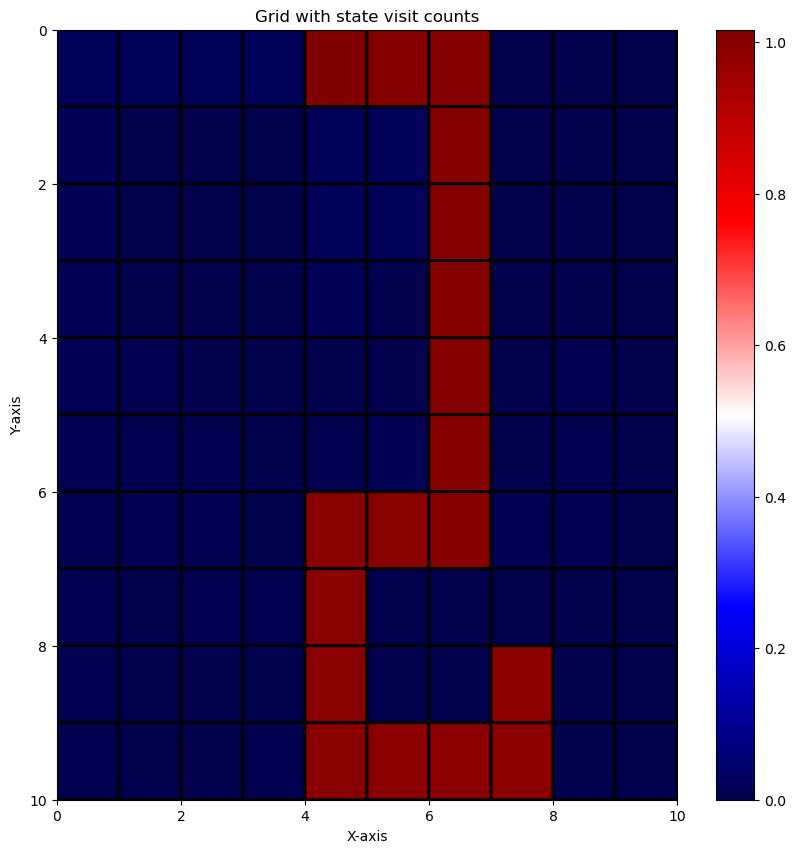

In [690]:
visualize_steps_heatmap((np.mean(steps_visted,0)))

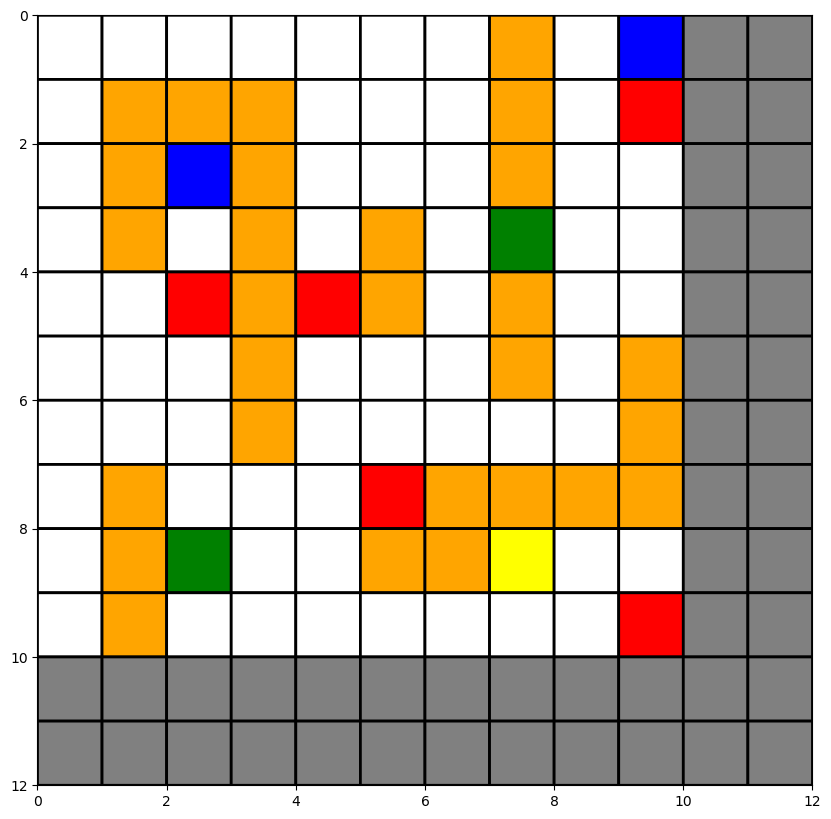

Steps: 17, Total Reward: -6


In [691]:

state = env_1.reset()
start_state = seq_to_col_row(state,num_cols)

done = False
steps = 0
tot_reward = 0
dummy_grid = np.zeros((num_rows+2, num_cols+2))


while not done:
    clear_output(wait=True)
    max_indices = np.where(Q[state] == np.max(Q[state]))[0]

    random_max_index = np.random.choice(max_indices)

    state, reward, done = env_1.step(state, random_max_index)
    dummy_grid[tuple(zip(*start_state))] = 0  # Start State - yellow
    start_state = seq_to_col_row(state,num_cols)
    dummy_grid[tuple(zip(*start_state))] = 5  # Start State - yellow
    
    plt.figure(figsize=(num_cols, num_rows))

    visualize_grid(dummy_grid, obstructions,bad_states,restart_states,goal_states,outside,start_state,plt)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

## Q- Learning

In [692]:
# initialize Q-value
Q = np.zeros((env_1.num_states, env_1.num_actions))

alpha0 = 0.3
gamma = 0.9
episodes = 10000
epsilon0 = 0.3
tau0 = 0.3

In [693]:
print_freq = 500

def qlearning(env, Q, gamma = 0.9,alpha =0.4,plot_heat=False,  choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visits =  np.zeros((episodes,env.num_rows,num_cols))
    if plot_heat:
        clear_output(wait=True)
        visulaize_Q_optimal(Q)

    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        state_nseq = seq_to_col_row(state,num_cols).flatten()
        state_visits[ep][state_nseq[0]][[state_nseq[1]]] +=1
        while not done:
            state_next, reward, done = env.step(state,action)
            action_next = choose_action(Q, state_next)
            
            Q[state,action] += alpha*(reward + gamma*np.max(Q[state_next]) - Q[state,action])                       
            tot_reward += reward
            steps += 1
            
            state_nseq = seq_to_col_row(state_next,num_cols).flatten()
            state_visits[ep][state_nseq[0]][[state_nseq[1]]] +=1
             
            state, action = state_next, action_next
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            visulaize_Q_optimal(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
       
                
    return Q, episode_rewards, steps_to_completion,state_visits

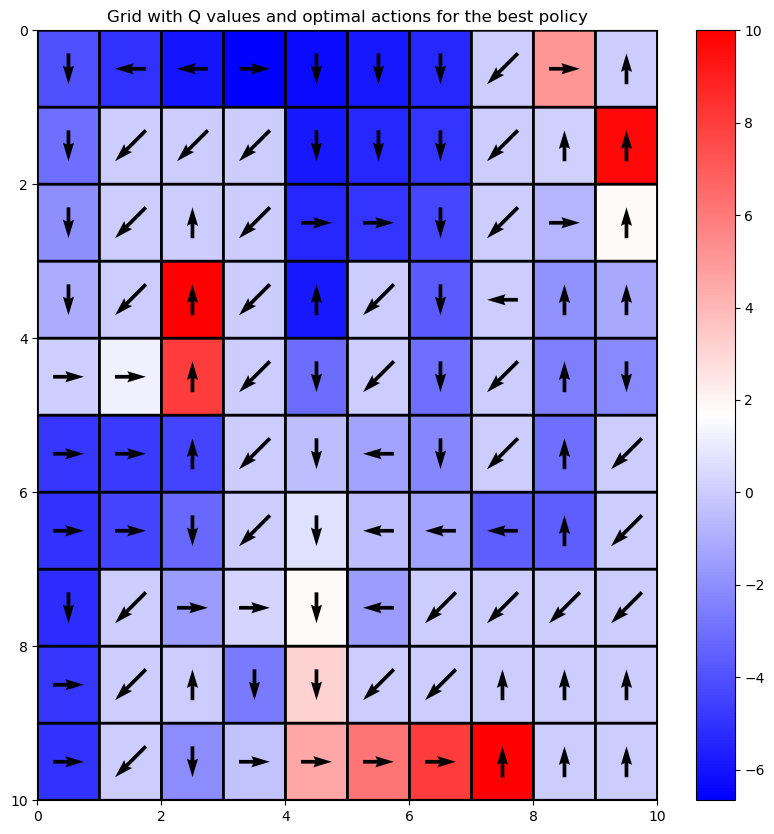

100%|██████████| 10000/10000 [00:12<00:00, 792.15it/s]


In [694]:
Q = np.zeros((env_1.num_states, env_1.num_actions))

Q, rewards, steps,state_visits = qlearning(env_1, Q, gamma = gamma,alpha=alpha0,plot_heat=True, choose_action=lambda Q, state: choose_action_softmax(Q, state, tau0,rg))

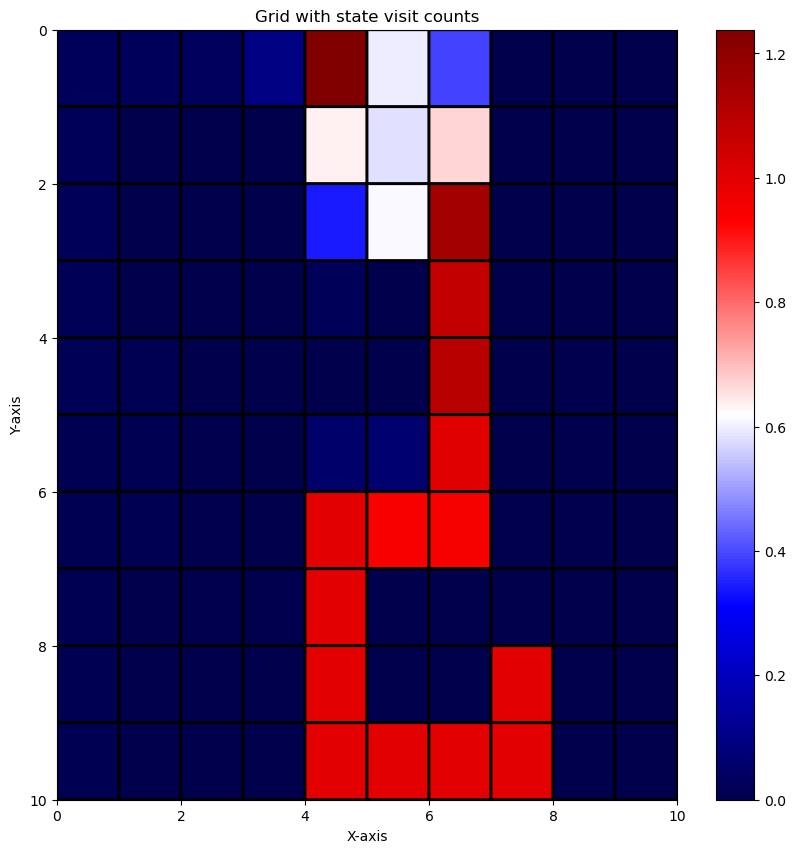

In [695]:
visualize_steps_heatmap((np.mean(state_visits,0)))

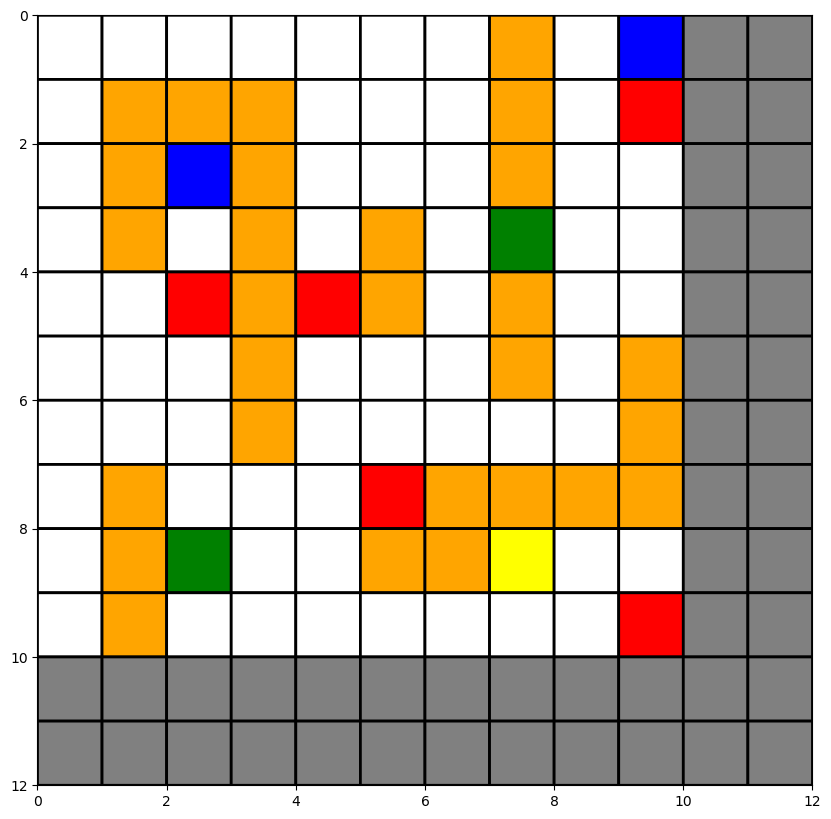

Steps: 17, Total Reward: -6


In [696]:

state = env_1.reset()
start_state = seq_to_col_row(state,num_cols)

done = False
steps = 0
tot_reward = 0
dummy_grid = np.zeros((num_rows+2, num_cols+2))


while not done:
    clear_output(wait=True)
    max_indices = np.where(Q[state] == np.max(Q[state]))[0]

    random_max_index = np.random.choice(max_indices)

    state, reward, done = env_1.step(state, random_max_index)
    dummy_grid[tuple(zip(*start_state))] = 0  # Start State - yellow
    start_state = seq_to_col_row(state,num_cols)
    dummy_grid[tuple(zip(*start_state))] = 5  # Start State - yellow
    
    plt.figure(figsize=(num_cols, num_rows))

    visualize_grid(dummy_grid, obstructions,bad_states,restart_states,goal_states,outside,start_state,plt)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

## Hyperparameters evaluation

### To get the best set of hyperparameters for 12 experiments
-  - 2 start states -> [0,4],[3,6]
-  - 3 variants of stochasticity:
    1. &nbsp; wind=False(clear), p = 1.0(deterministic step).
    2. wind=False(clear), p = 0.7(stochastic step).
    3. wind=True(windy), p = 1.0(deterministic step).
- - 2 algos -> SARSA, Q-Learning
- τ in softmax or ϵ in ϵ-greedy
- Learning rate α
- Discount factor γ 
- best action selection policy(ϵ-greedy or softmax)

In [697]:
start_states = np.array([[[0,4]],[[3,6]]])
envs = []
for i in range(2):
    # create model
    gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_states[i],
                goal_states=goal_states, wind = False)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                bias=0)
    envs.append(gw.create_gridworld())

    gw2 = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_states[i],
                goal_states=goal_states, wind = False)
    gw2.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw2.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)

    gw2.add_transition_probability(p_good_transition=0.7,
                                bias=0.5)
    envs.append(gw2.create_gridworld())
    

    gw3 = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_states[i],
                goal_states=goal_states, wind = True)
    gw3.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw3.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw3.add_transition_probability(p_good_transition=1,
                                bias=0)

    envs.append(gw3.create_gridworld())


In [698]:
envs[1].P[0,:,0]

array([0.85, 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [699]:
algos = [sarsa, qlearning]
policies = [choose_action_epsilon, choose_action_softmax]


In [701]:
episodes = 10000
alpha_range = np.linspace(0.1, 1, 10,endpoint=False)  
epsilon_range = np.array([0.1,0.2]) 
tau_range = np.array([0.1,0.2,0.3])  
gamma_range = np.array([0.9,0.95])  

# Create a list of hyperparameter combinations using Cartesian product
hyperparameters_list = list(itertools.product(alpha_range, gamma_range))
# Perform experiments
best_hyperparameters = {}  # Dictionary to store the best hyperparameters for each experiment
best_policy = {}  # Dictionary to store the best policy for each experiment
all_results = {}
try:
    interim_results = joblib.load('results.joblib')
except FileNotFoundError:
    interim_results = {}

In [702]:
interim_results

{(0, 4, False, 1, 'sarsa'): [(0.9099999999999999, 0.95, 0.2),
  <function __main__.choose_action_softmax(Q, state, tau, rg=RandomState(MT19937) at 0x7F1BCB4F7440)>,
  [array([[ -9.30722638,  -9.06798684,  -8.70274962,  -9.09926218],
          [ -9.09459083,  -9.14400697,  -8.67136715,  -9.21921729],
          [ -8.93319925,  -8.82912519,  -8.83185466,  -9.41212403],
          [ -9.72051807,  -9.38974048,  -9.22463598, -10.30426023],
          [-10.21296028,  -6.79619994, -10.66778703, -10.26404594],
          [ -9.99718579,  -7.55215454, -10.52162746, -10.11436998],
          [ -9.1778064 ,  -9.76061647, -10.58863707,  -9.76534718],
          [  0.        ,   0.        ,   0.        ,   0.        ],
          [ -0.91      ,   0.        ,   0.        ,  10.        ],
          [  0.        ,   0.        ,   0.        ,   0.        ],
          [ -9.17186848,  -7.80911556,  -8.88449472,  -8.78715708],
          [  0.        ,   0.        ,   0.        ,   0.        ],
          [  0.    

In [703]:

for sno,(env, algorithm) in enumerate(itertools.product(envs, algos),start=1):
    print(f"{sno}. Experiment with environment start_state: {env.start_state[0]}, wind: {env.wind}, p = {env.p_good_trans}, algorithm: {algorithm.__name__}\n")
    best_reward = -np.inf
    best_hyperparameter_combination = None
    best_policy_combination = None
    results = None
    config_key = (env.start_state[0][0],env.start_state[0][1],env.wind,env.p_good_trans, algorithm.__name__)

    if config_key in interim_results:
        best_hyperparameter_combination,best_policy_combination,results = interim_results[config_key]
        best_hyperparameters[(env,algorithm)] = best_hyperparameter_combination
        best_policy[(env,algorithm)] = best_policy_combination
        all_results[(env,algorithm)] = results
        print("\nRetrieved....\n")
        continue

    for chosen_policy in policies:
        policy_hyperparamter_list  = [] 
        if(chosen_policy.__name__ == 'choose_action_epsilon'):
            policy_hyperparamter_list = epsilon_range
        else:
            policy_hyperparamter_list = tau_range

        for serial_no , (hyperparameters, policy_hyperparamter) in enumerate(itertools.product(hyperparameters_list,policy_hyperparamter_list),start=1):
            print(f" {serial_no}) Alpha: {hyperparameters[0]}, Gamma: {hyperparameters[1]}, epsilon/tau: {policy_hyperparamter}, policy: {chosen_policy.__name__}")

            Q = np.zeros((env.num_states, env.num_actions))
            Q, rewards, steps,state_steps = algorithm(env, Q, gamma = hyperparameters[1],alpha=hyperparameters[0], choose_action=lambda Q, state: chosen_policy(Q, state, policy_hyperparamter,rg))
                # interim_results[config_key] = [Q, rewards, steps, state_steps]

            mean_reward = np.mean(rewards)
            if mean_reward > best_reward:
                best_reward = mean_reward
                best_hyperparameter_combination = hyperparameters + (policy_hyperparamter,)
                best_policy_combination= chosen_policy
                results = [Q, rewards, steps, state_steps]


     # Store the best hyperparameters and policy for this experiment
                
    best_hyperparameters[(env,algorithm)] = best_hyperparameter_combination
    best_policy[(env,algorithm)] = best_policy_combination
    all_results[(env,algorithm)] = results
    print("\nSaved....\n")
    interim_results[config_key] = [best_hyperparameter_combination,best_policy_combination, results]
    joblib.dump(interim_results, 'results.joblib')

    print(f"Environment {sno} completed...\n\n")    


1. Experiment with environment start_state: [0 4], wind: False, p = 1, algorithm: sarsa


Retrieved....

2. Experiment with environment start_state: [0 4], wind: False, p = 1, algorithm: qlearning


Retrieved....

3. Experiment with environment start_state: [0 4], wind: False, p = 0.7, algorithm: sarsa


Retrieved....

4. Experiment with environment start_state: [0 4], wind: False, p = 0.7, algorithm: qlearning


Retrieved....

5. Experiment with environment start_state: [0 4], wind: True, p = 1, algorithm: sarsa


Retrieved....

6. Experiment with environment start_state: [0 4], wind: True, p = 1, algorithm: qlearning


Retrieved....

7. Experiment with environment start_state: [3 6], wind: False, p = 1, algorithm: sarsa


Retrieved....

8. Experiment with environment start_state: [3 6], wind: False, p = 1, algorithm: qlearning


Retrieved....

9. Experiment with environment start_state: [3 6], wind: False, p = 0.7, algorithm: sarsa


Retrieved....

10. Experiment with environment sta

(<__main__.GridWorld object at 0x7f1bcb661f50>, <function sarsa at 0x7f1be18b4fe0>)
1. Experiment with environment start_state: [0 4], wind: False, p = 1, algorithm: sarsa

Best hyperparameters for the above experiment:

 1) Alpha:0.9099999999999999, Gamma:0.95, tau: 0.2, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:06<00:00, 1621.06it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:08<00:00, 1247.32it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:07<00:00, 1321.96it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:07<00:00, 1355.22it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:07<00:00, 1347.19it/s]


Rewards:
 -6.85404
Steps:
 16.78254 



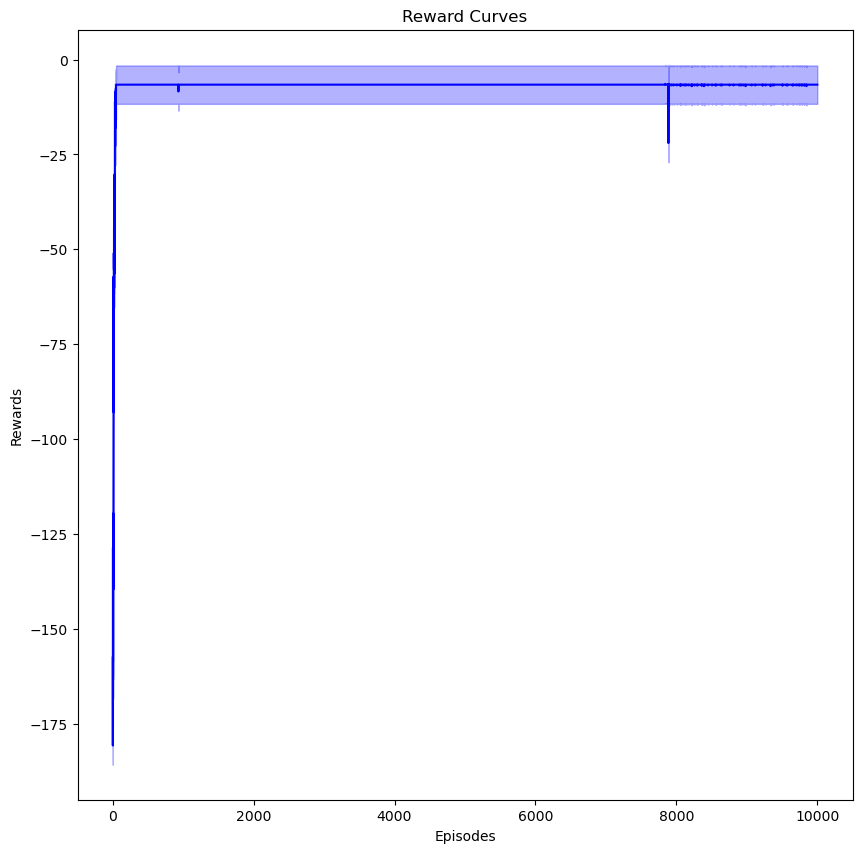

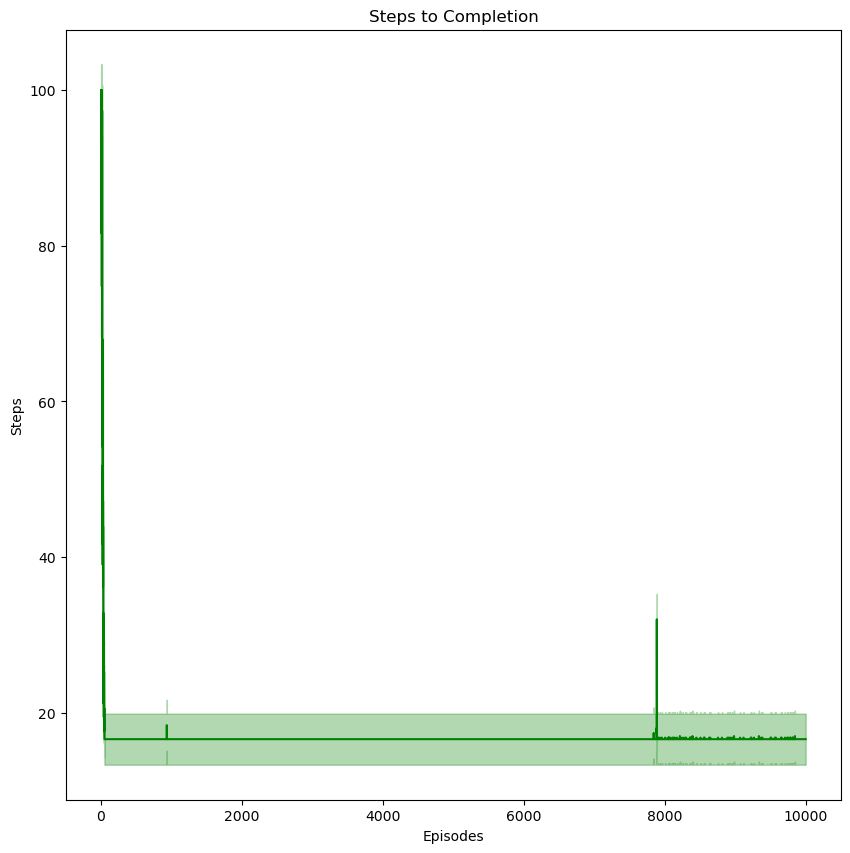

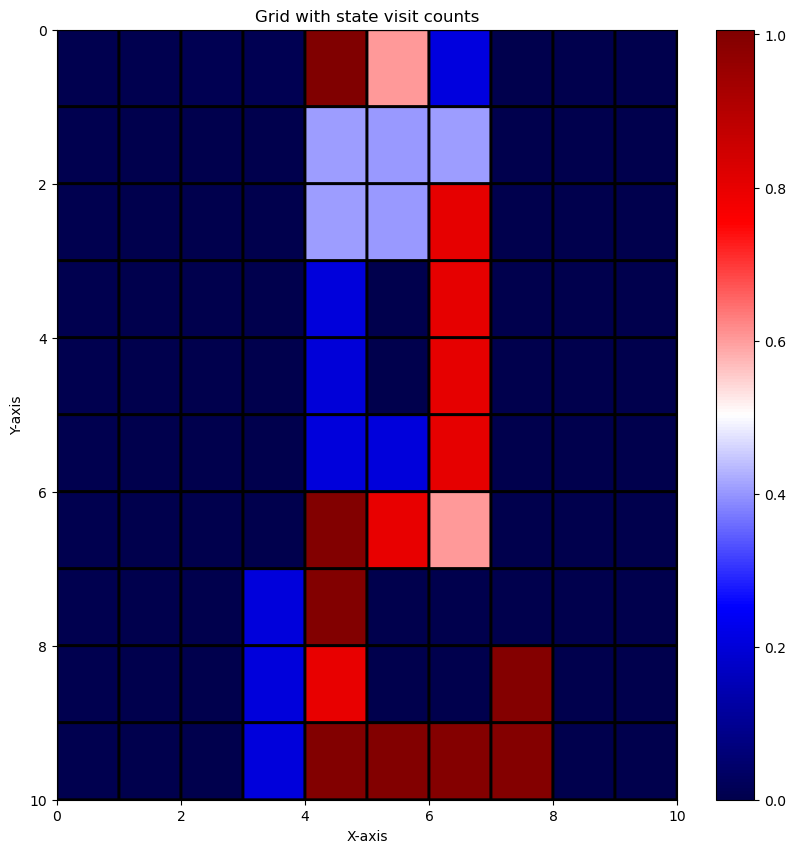

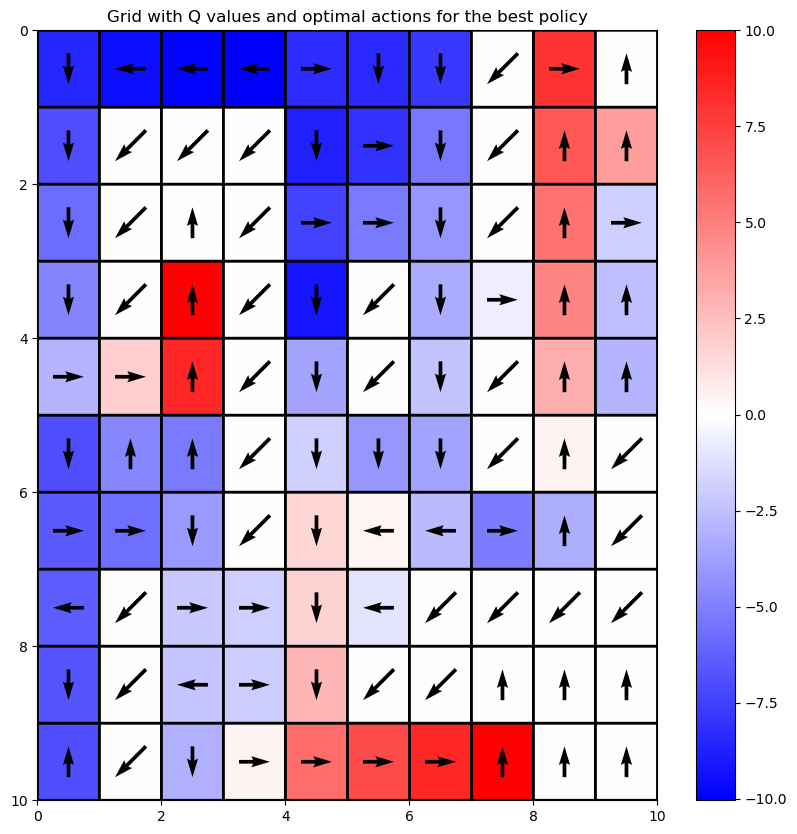

(<__main__.GridWorld object at 0x7f1bcb661f50>, <function qlearning at 0x7f1bcb707a60>)
2. Experiment with environment start_state: [0 4], wind: False, p = 1, algorithm: qlearning

Best hyperparameters for the above experiment:

 2) Alpha:0.28, Gamma:0.95, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:07<00:00, 1293.17it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:07<00:00, 1312.03it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:07<00:00, 1308.16it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:07<00:00, 1294.93it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:07<00:00, 1274.80it/s]


Rewards:
 -6.46128
Steps:
 17.36132 



<Figure size 640x480 with 0 Axes>

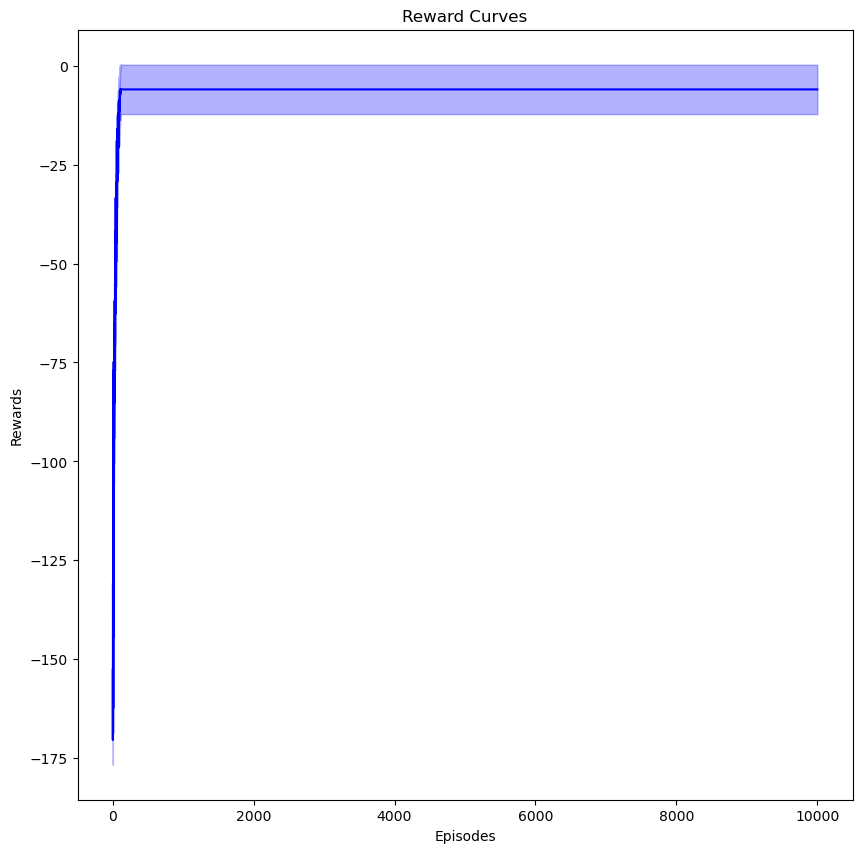

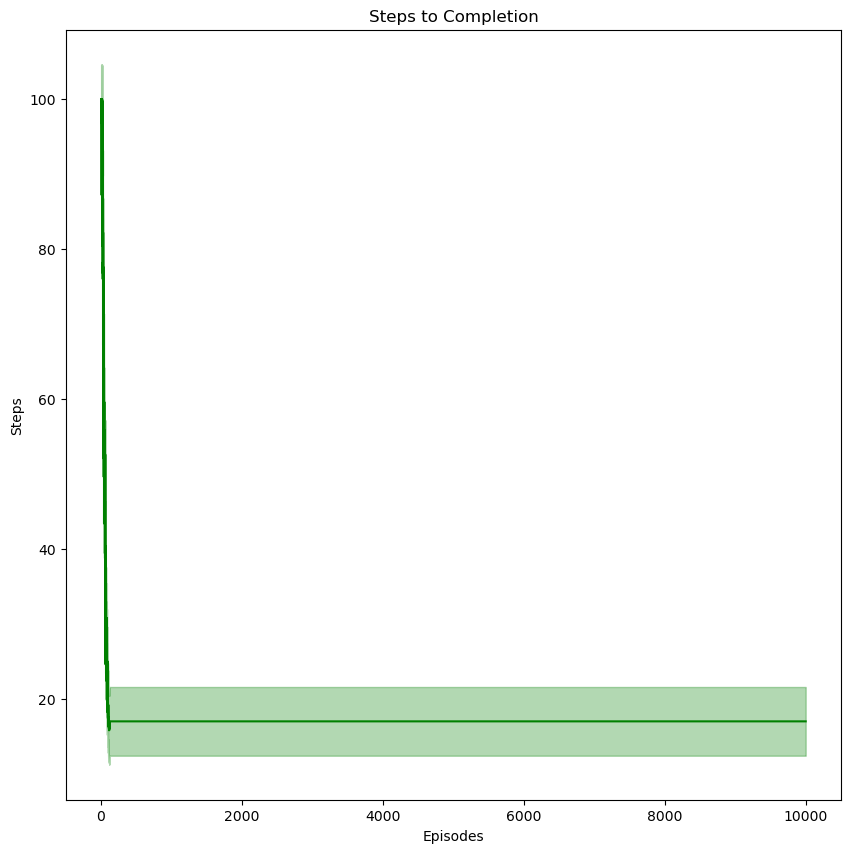

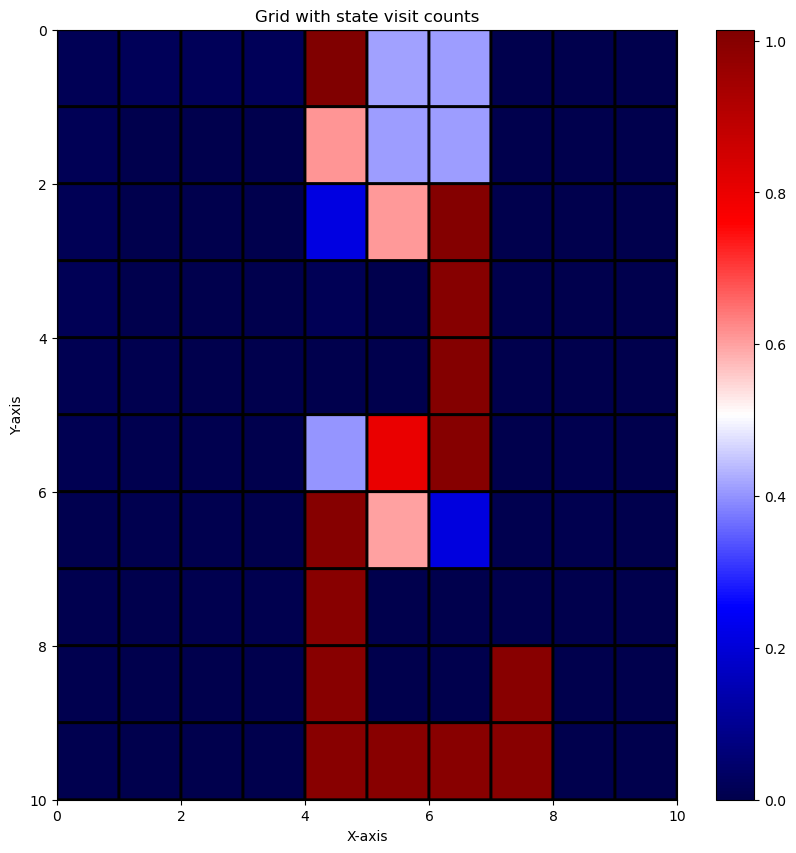

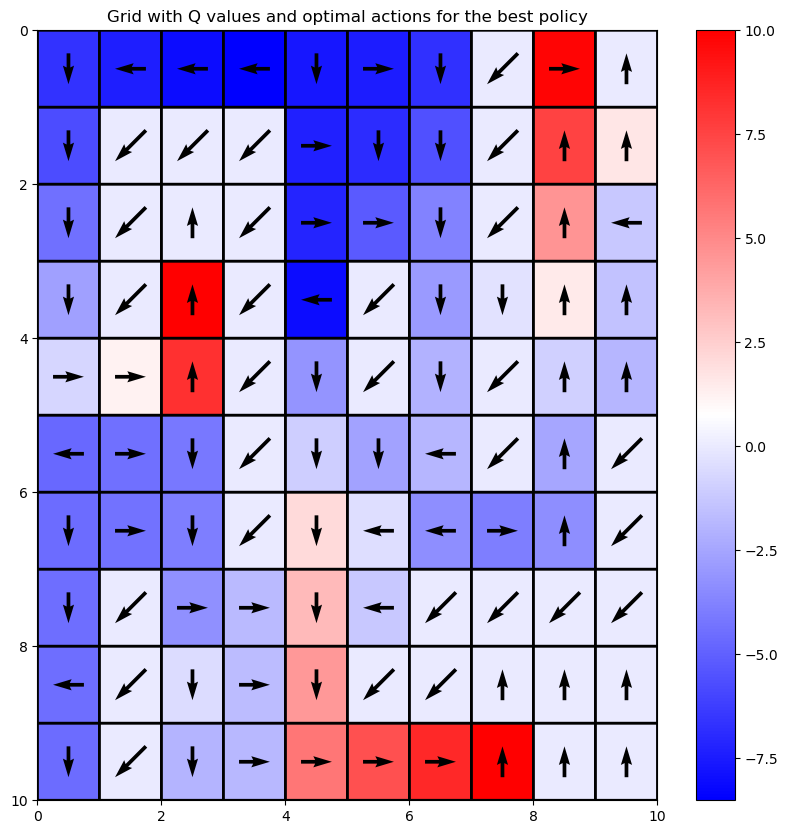

(<__main__.GridWorld object at 0x7f1bcae35f50>, <function sarsa at 0x7f1be18b4fe0>)
3. Experiment with environment start_state: [0 4], wind: False, p = 0.7, algorithm: sarsa

Best hyperparameters for the above experiment:

 3) Alpha:0.28, Gamma:0.95, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:07<00:00, 1312.56it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:07<00:00, 1368.39it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:07<00:00, 1378.15it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:07<00:00, 1391.01it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:07<00:00, 1322.60it/s]


Rewards:
 -16.74104
Steps:
 20.39224 



<Figure size 640x480 with 0 Axes>

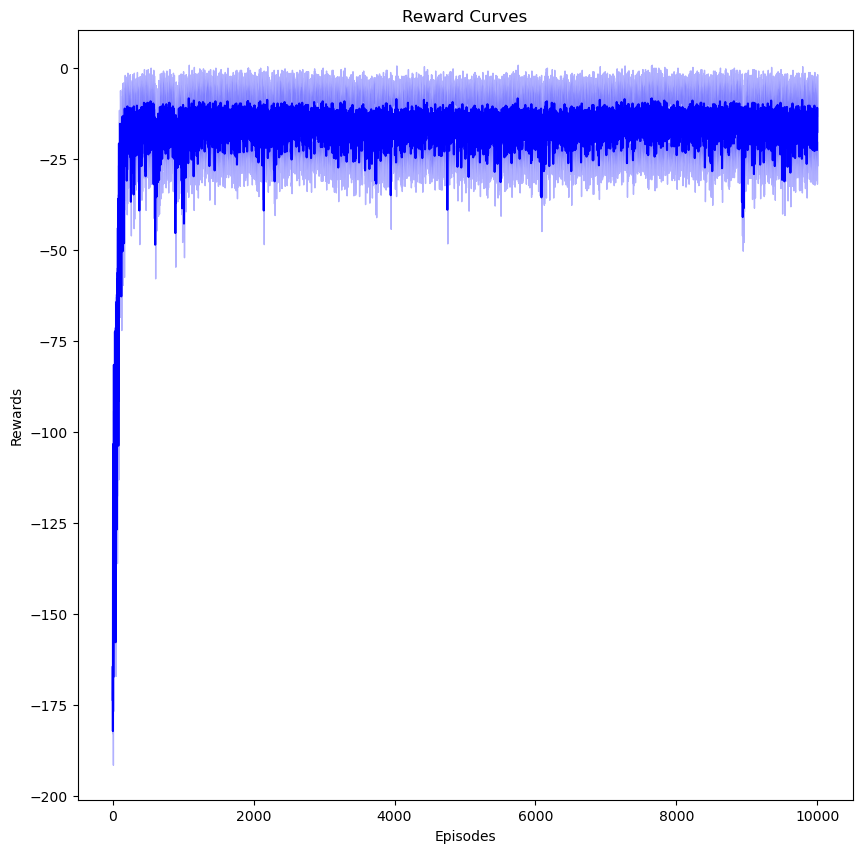

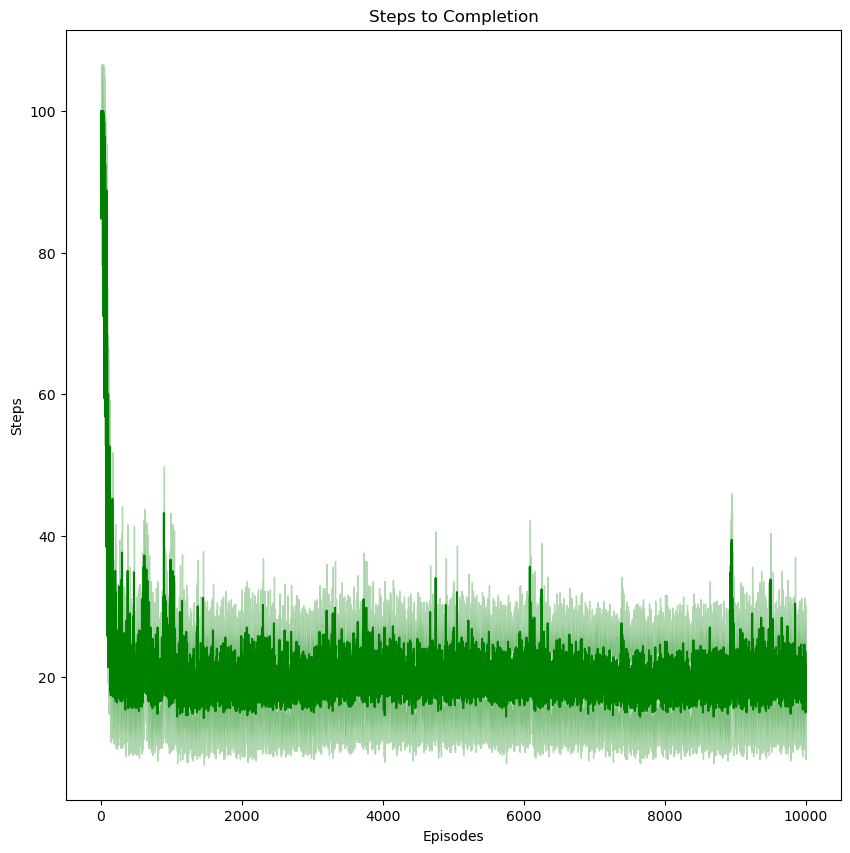

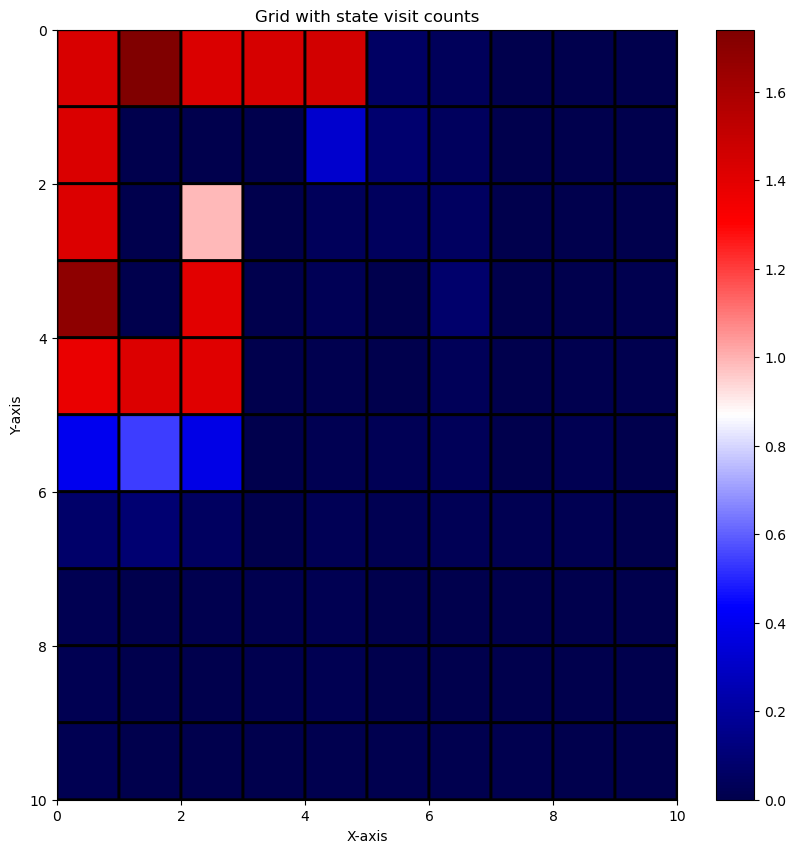

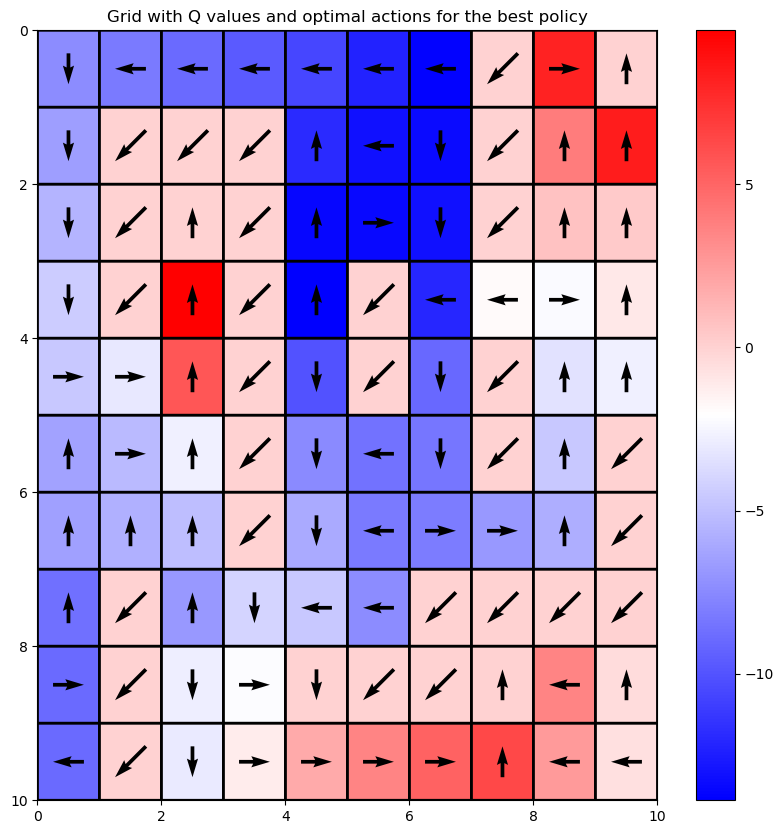

(<__main__.GridWorld object at 0x7f1bcae35f50>, <function qlearning at 0x7f1bcb707a60>)
4. Experiment with environment start_state: [0 4], wind: False, p = 0.7, algorithm: qlearning

Best hyperparameters for the above experiment:

 4) Alpha:0.37, Gamma:0.95, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:07<00:00, 1268.79it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:09<00:00, 1051.57it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:09<00:00, 1099.43it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:08<00:00, 1127.37it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:08<00:00, 1183.05it/s]


Rewards:
 -17.67184
Steps:
 21.31408 



<Figure size 640x480 with 0 Axes>

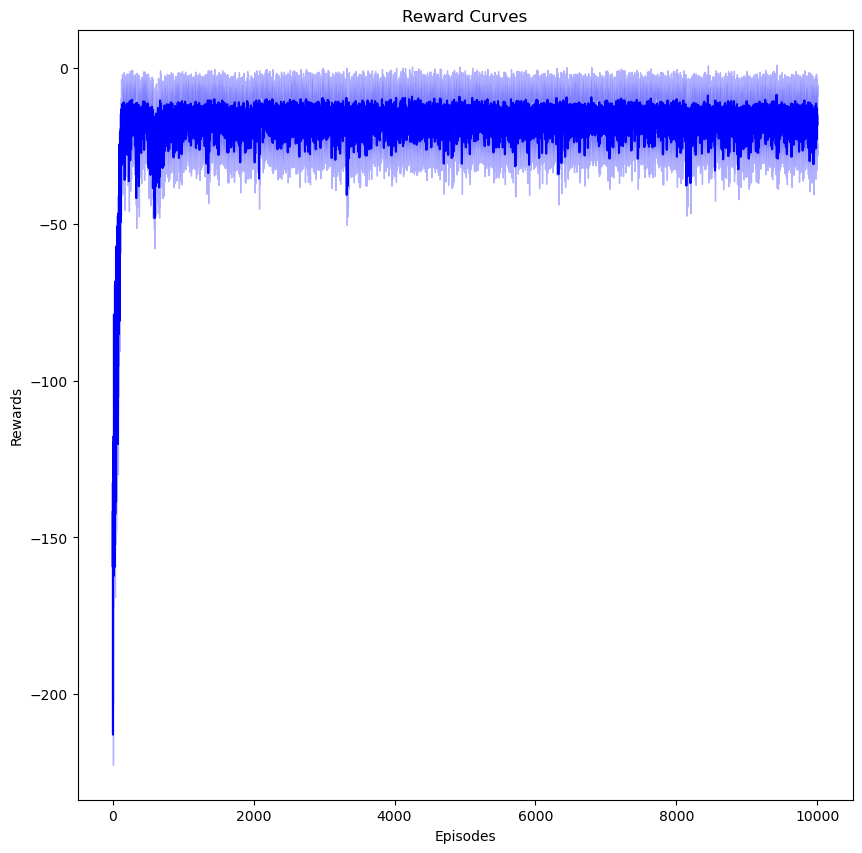

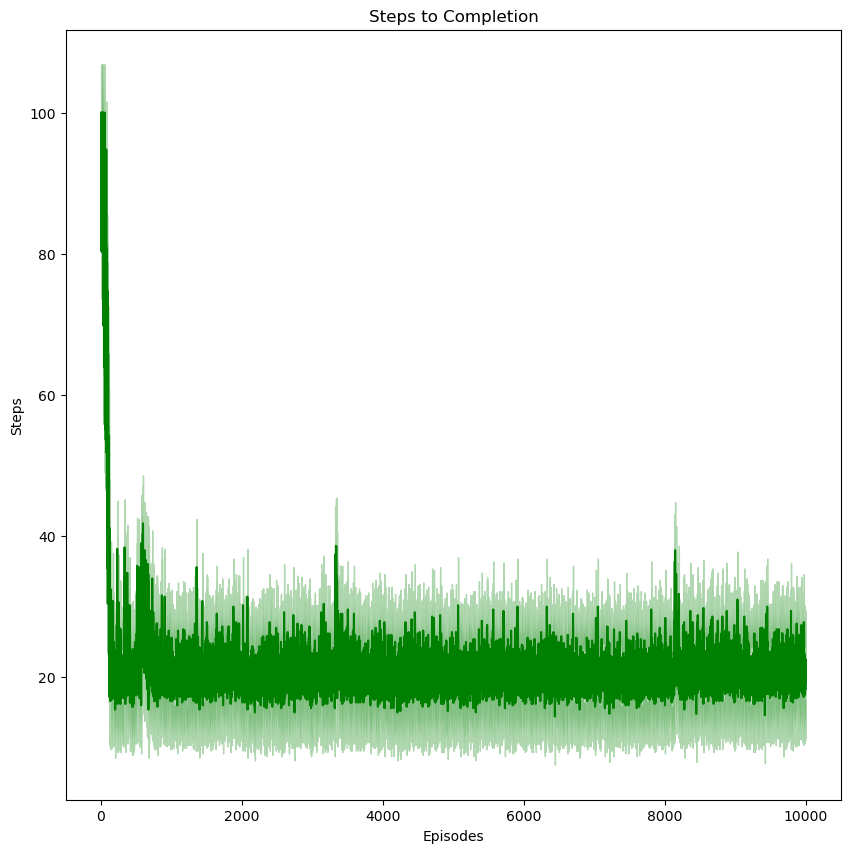

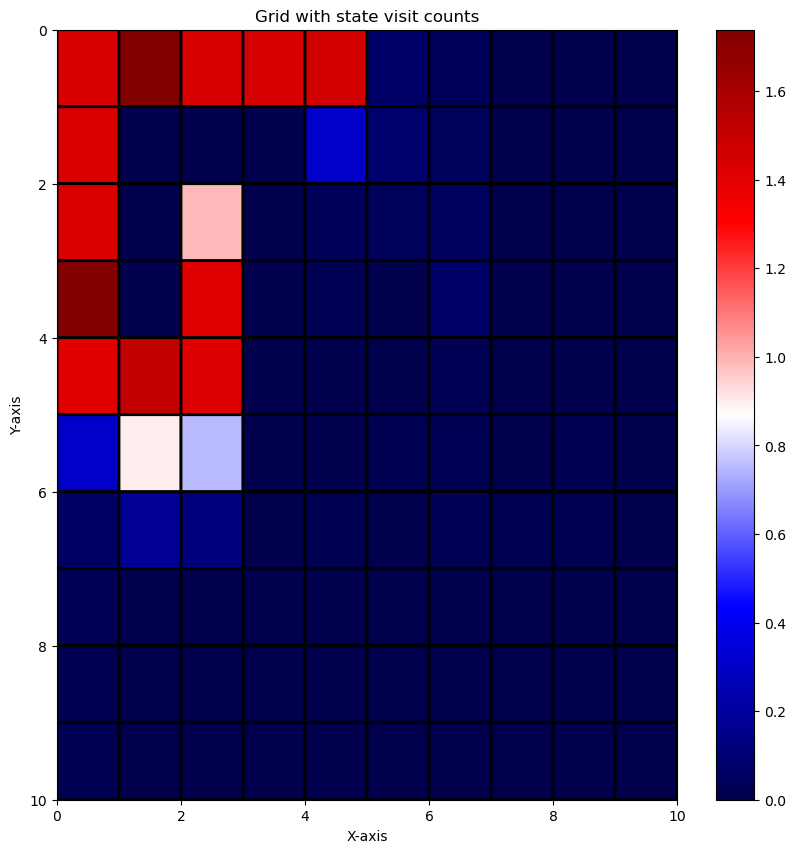

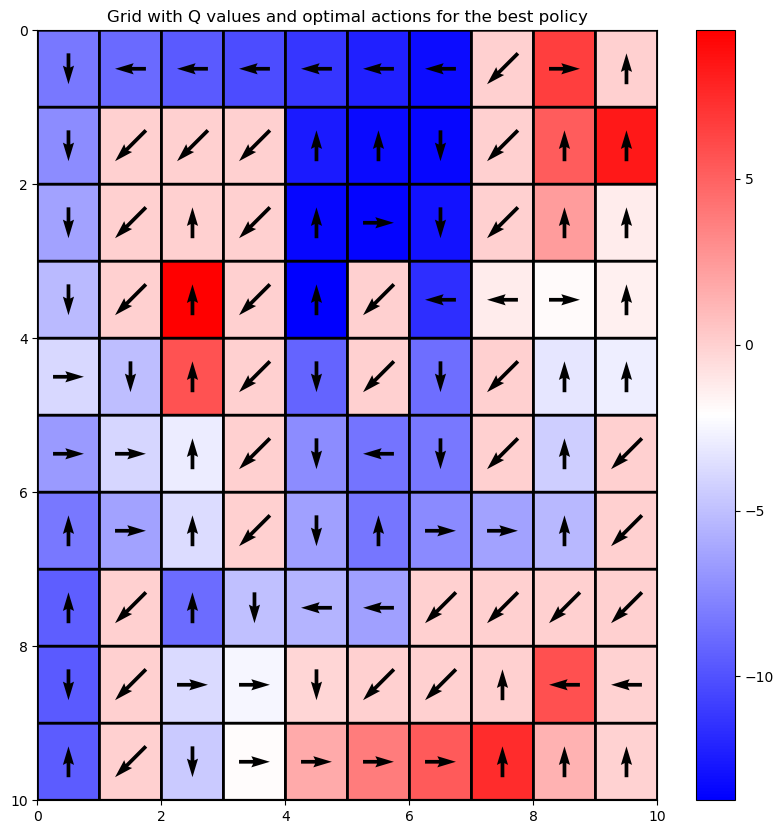

(<__main__.GridWorld object at 0x7f1bcbac0d90>, <function sarsa at 0x7f1be18b4fe0>)
5. Experiment with environment start_state: [0 4], wind: True, p = 1, algorithm: sarsa

Best hyperparameters for the above experiment:

 5) Alpha:0.64, Gamma:0.95, tau: 0.2, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:06<00:00, 1460.60it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:07<00:00, 1387.69it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:06<00:00, 1631.62it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:07<00:00, 1379.43it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:06<00:00, 1642.38it/s]


Rewards:
 -9.04314
Steps:
 15.20858 



<Figure size 640x480 with 0 Axes>

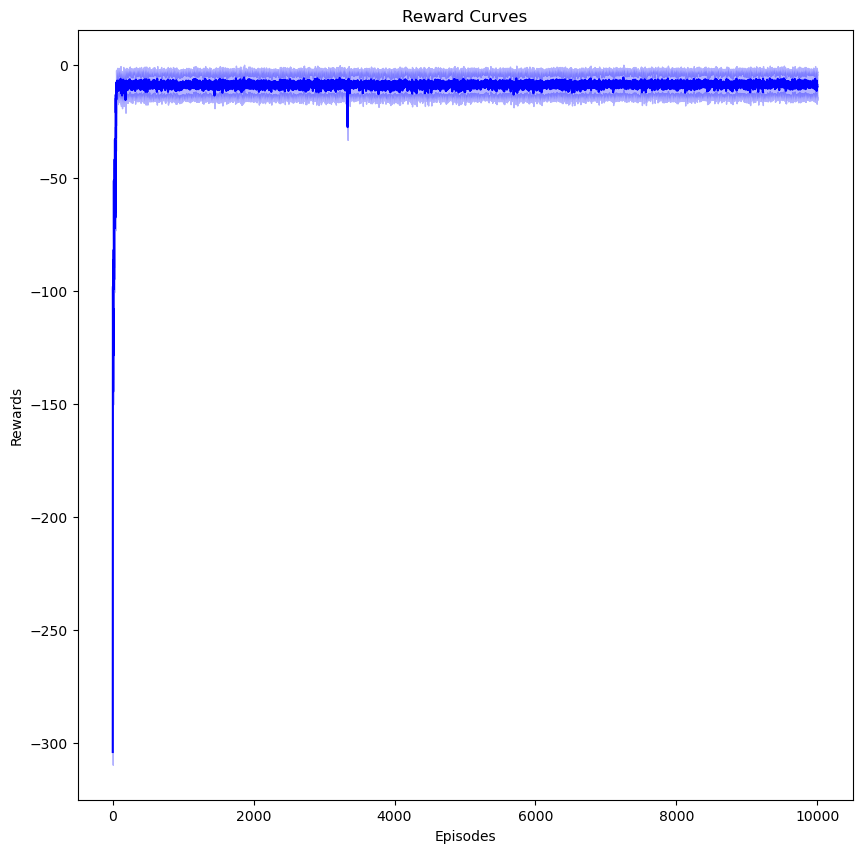

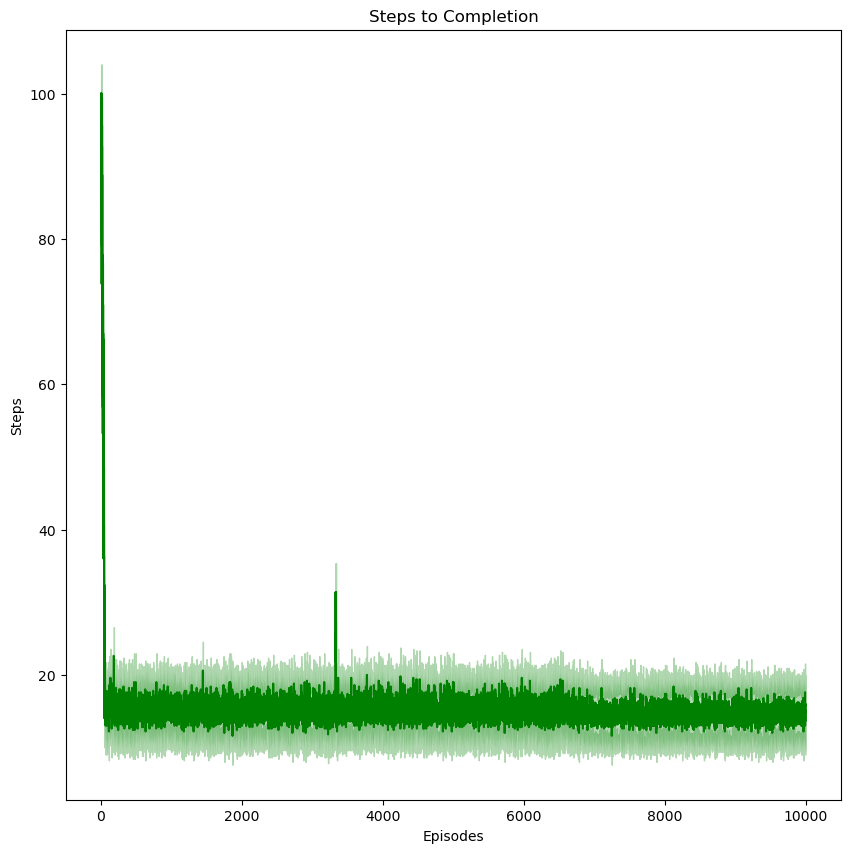

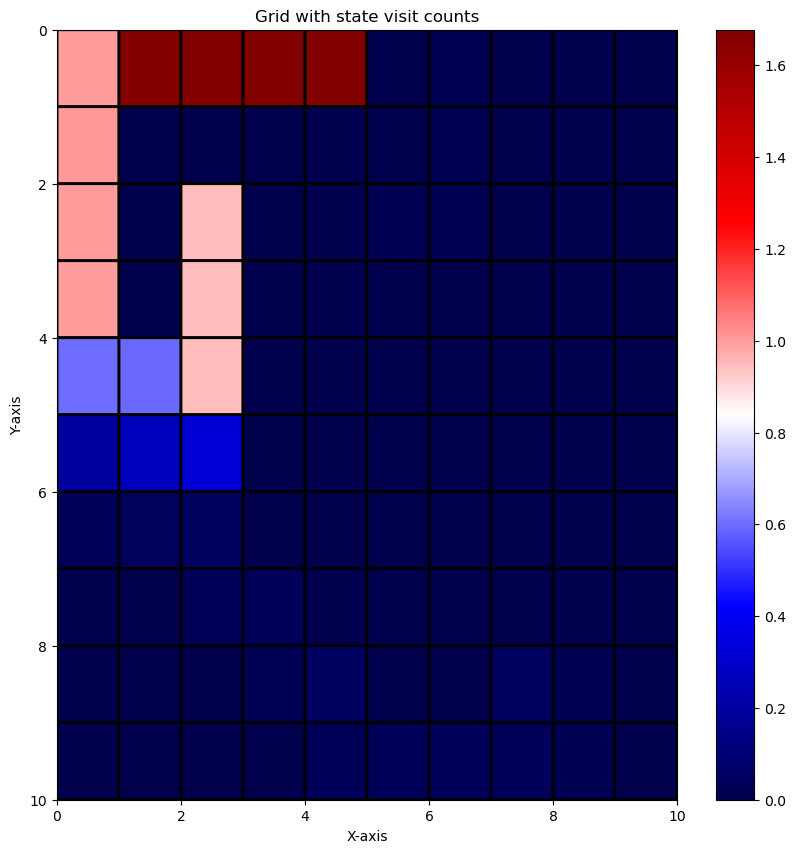

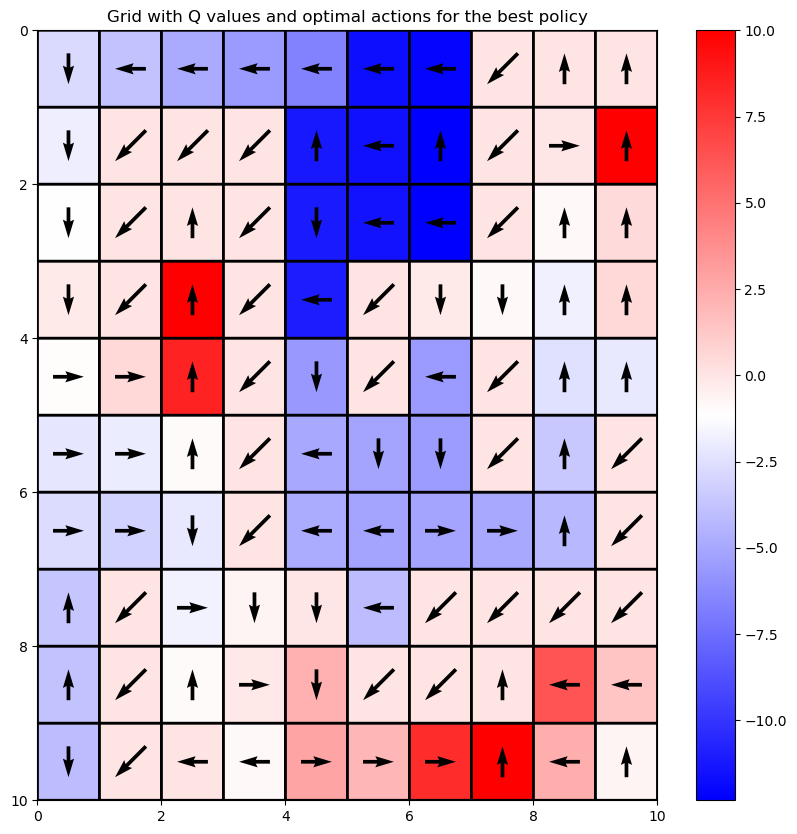

(<__main__.GridWorld object at 0x7f1bcbac0d90>, <function qlearning at 0x7f1bcb707a60>)
6. Experiment with environment start_state: [0 4], wind: True, p = 1, algorithm: qlearning

Best hyperparameters for the above experiment:

 6) Alpha:0.73, Gamma:0.9, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:06<00:00, 1513.14it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:06<00:00, 1554.21it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:06<00:00, 1618.92it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:05<00:00, 1682.87it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:06<00:00, 1516.51it/s]


Rewards:
 -8.50706
Steps:
 14.42946 



<Figure size 640x480 with 0 Axes>

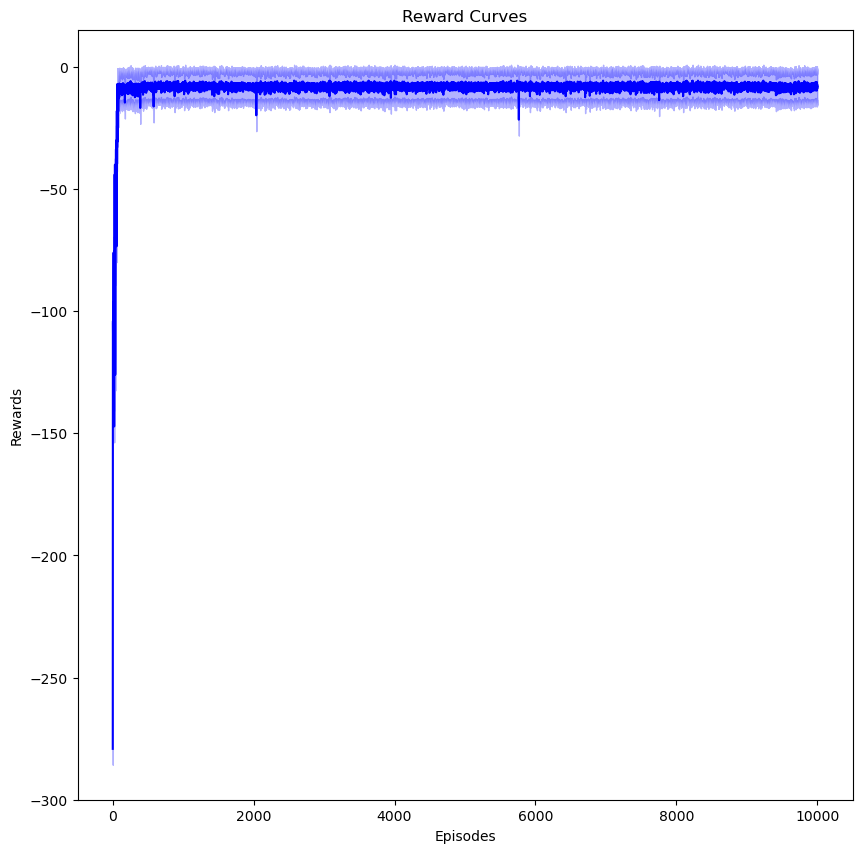

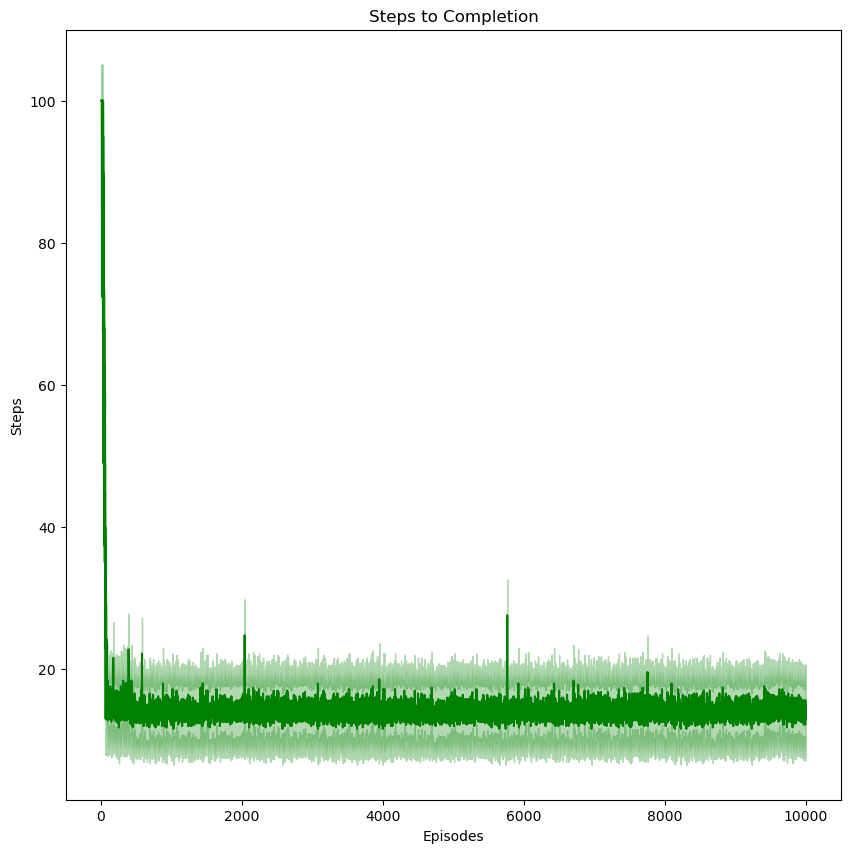

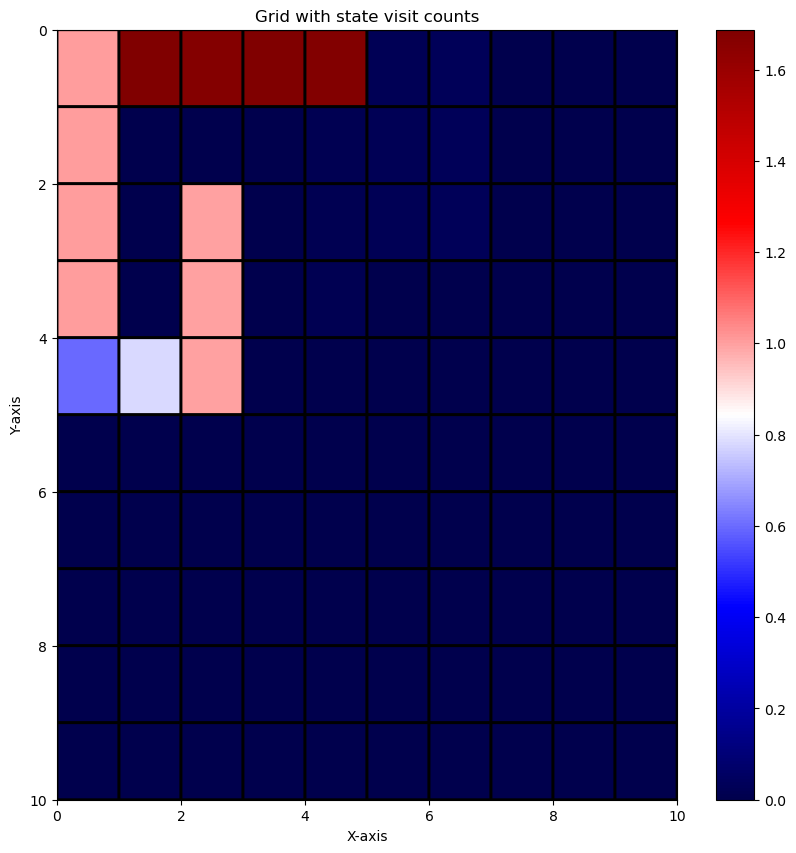

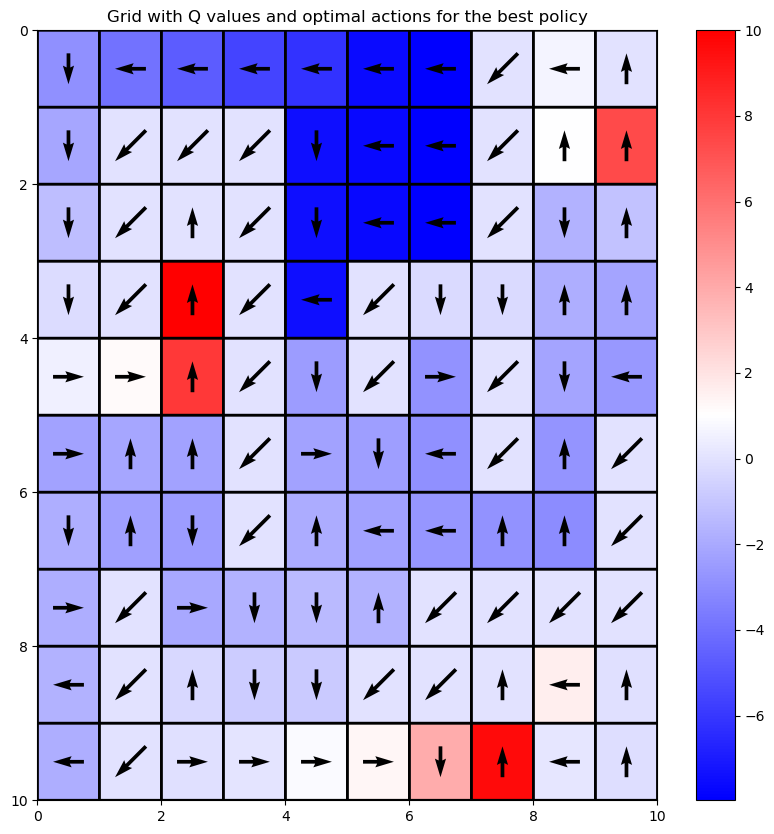

(<__main__.GridWorld object at 0x7f1bcbe35cd0>, <function sarsa at 0x7f1be18b4fe0>)
7. Experiment with environment start_state: [3 6], wind: False, p = 1, algorithm: sarsa

Best hyperparameters for the above experiment:

 7) Alpha:0.73, Gamma:0.95, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:06<00:00, 1581.38it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:06<00:00, 1581.58it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:05<00:00, 1874.88it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:05<00:00, 1749.19it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:05<00:00, 1841.08it/s]


Rewards:
 -1.2496
Steps:
 12.17328 



<Figure size 640x480 with 0 Axes>

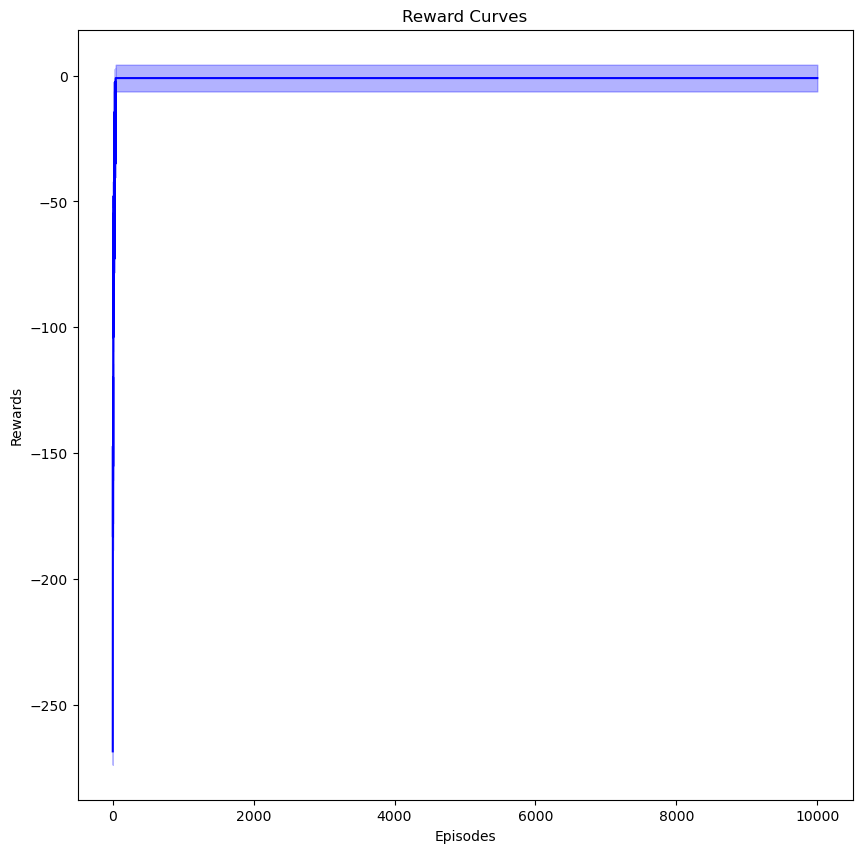

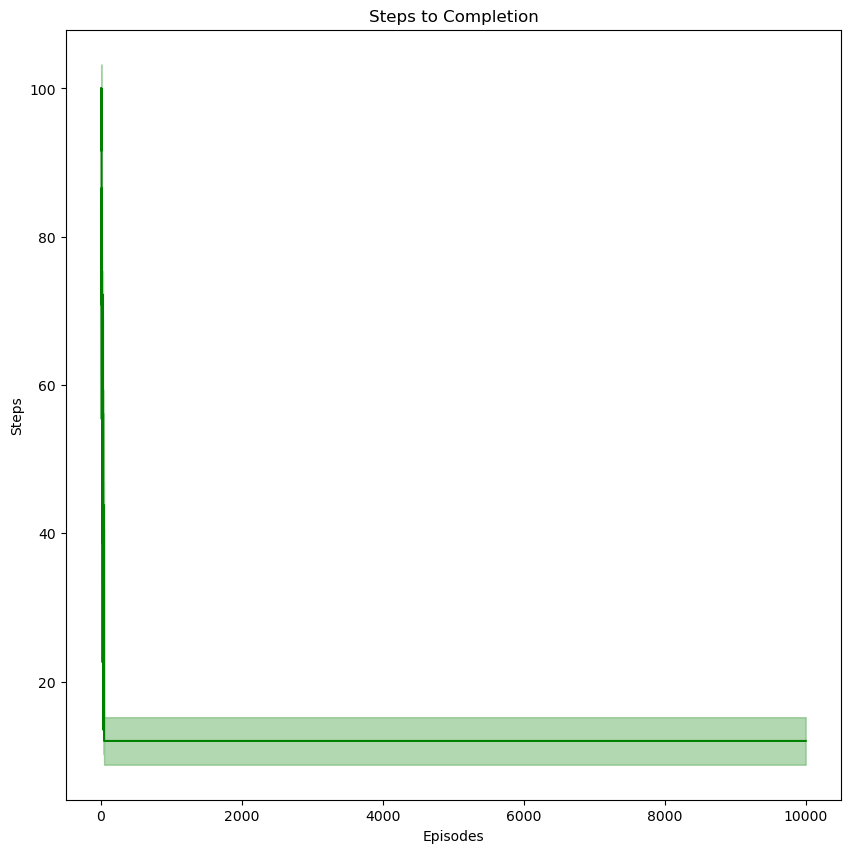

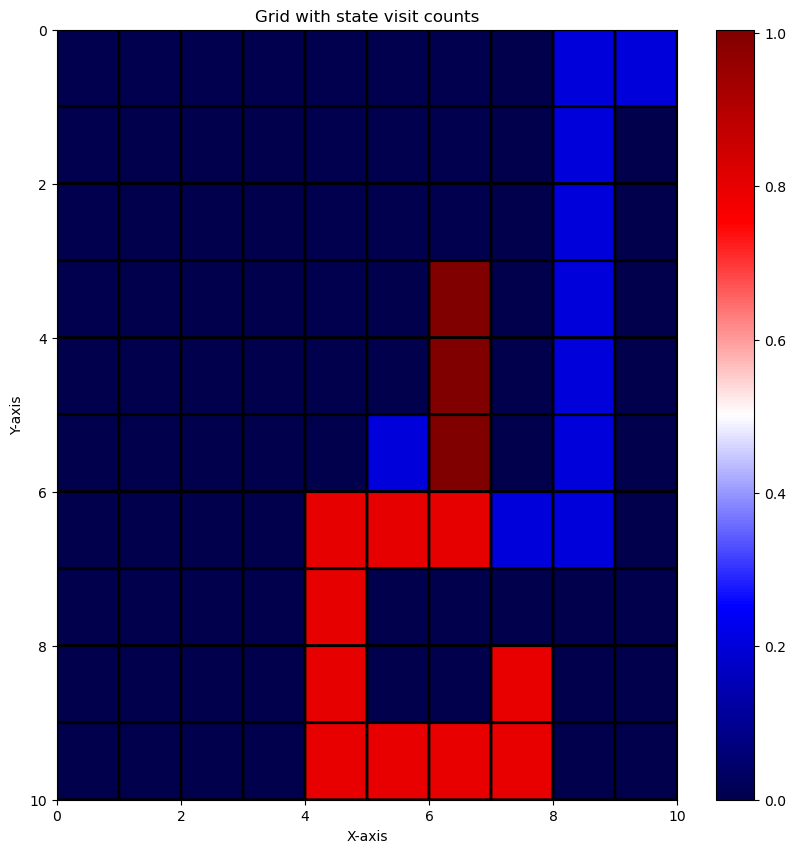

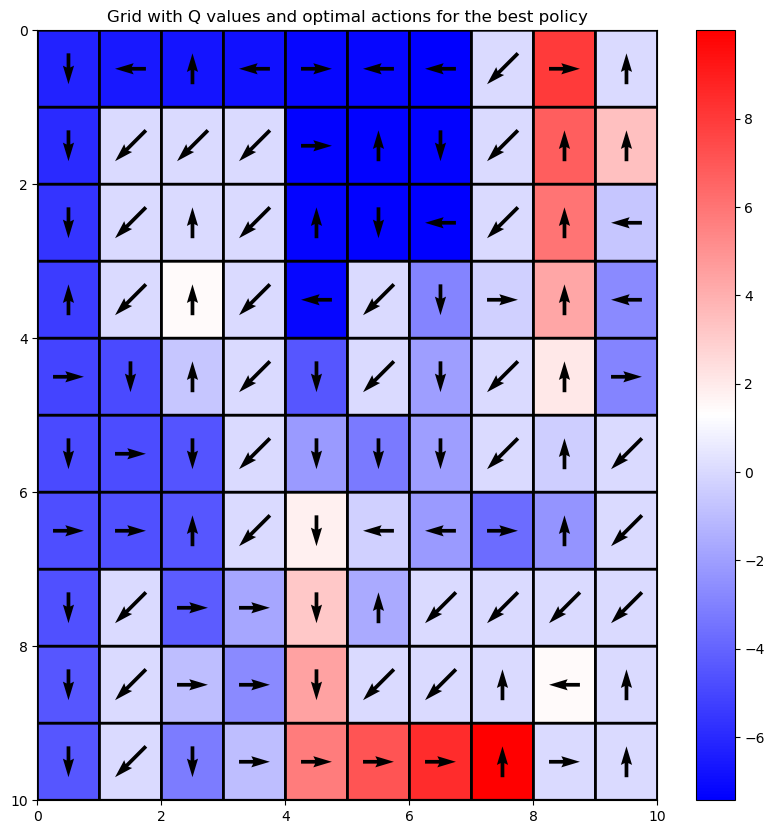

(<__main__.GridWorld object at 0x7f1bcbe35cd0>, <function qlearning at 0x7f1bcb707a60>)
8. Experiment with environment start_state: [3 6], wind: False, p = 1, algorithm: qlearning

Best hyperparameters for the above experiment:

 8) Alpha:0.28, Gamma:0.9, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:06<00:00, 1635.34it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:06<00:00, 1582.52it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:06<00:00, 1633.16it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:06<00:00, 1602.86it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:05<00:00, 1738.40it/s]


Rewards:
 -1.43054
Steps:
 12.33624 



<Figure size 640x480 with 0 Axes>

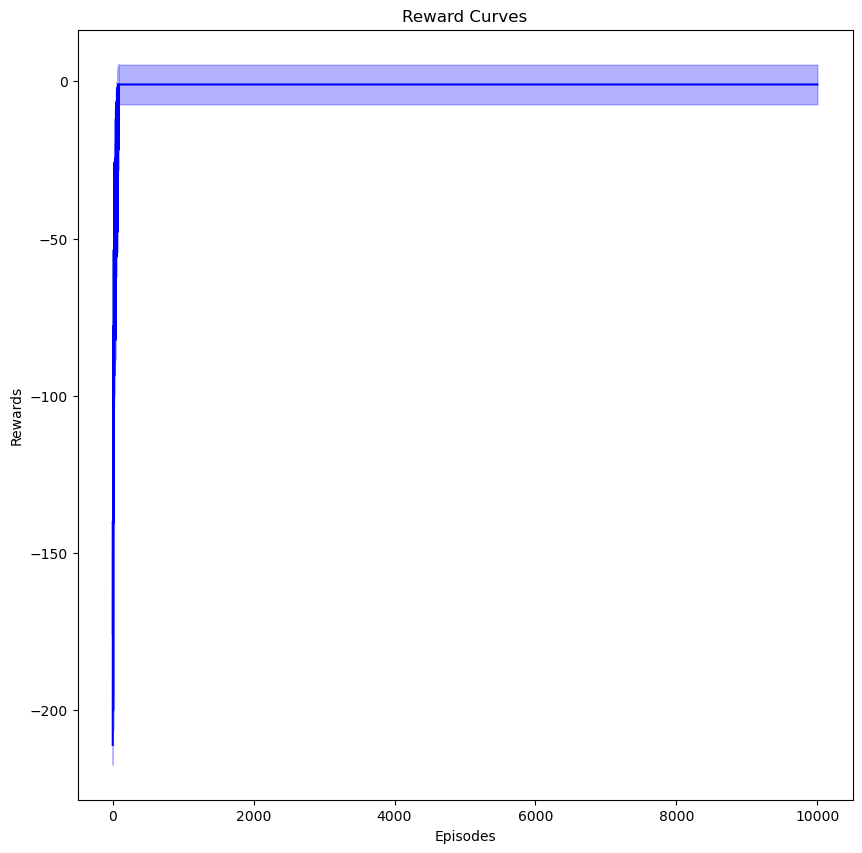

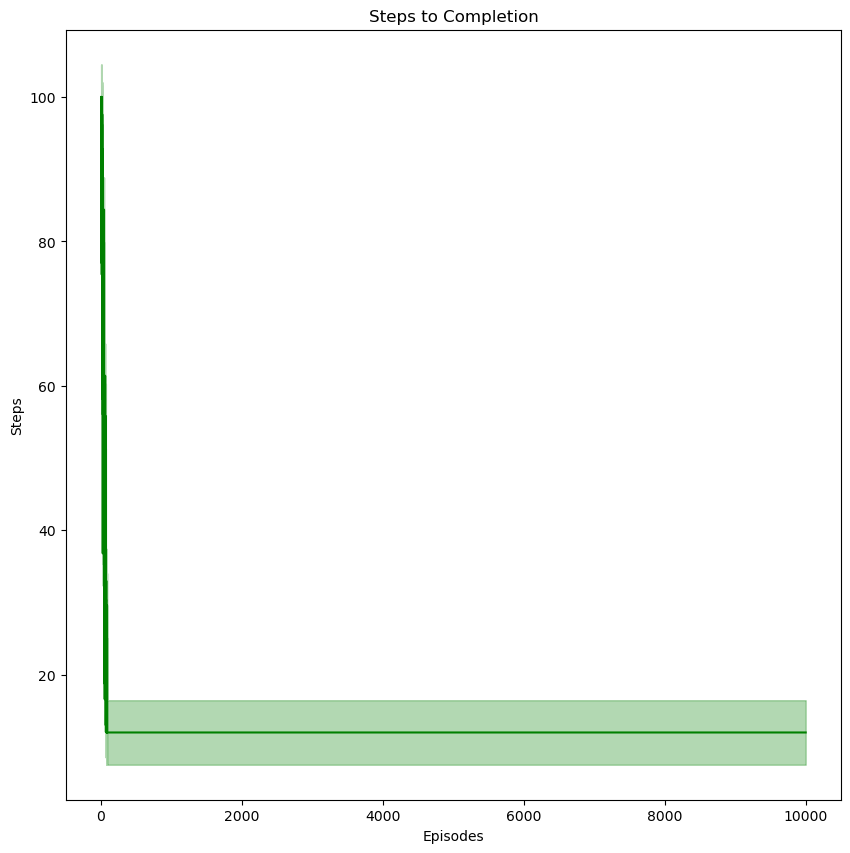

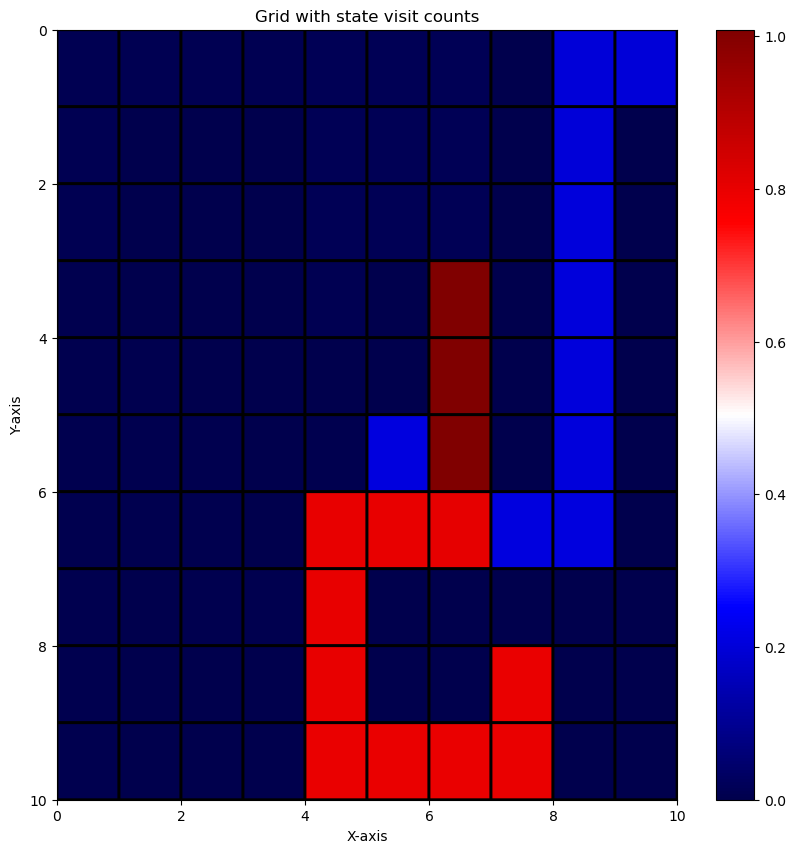

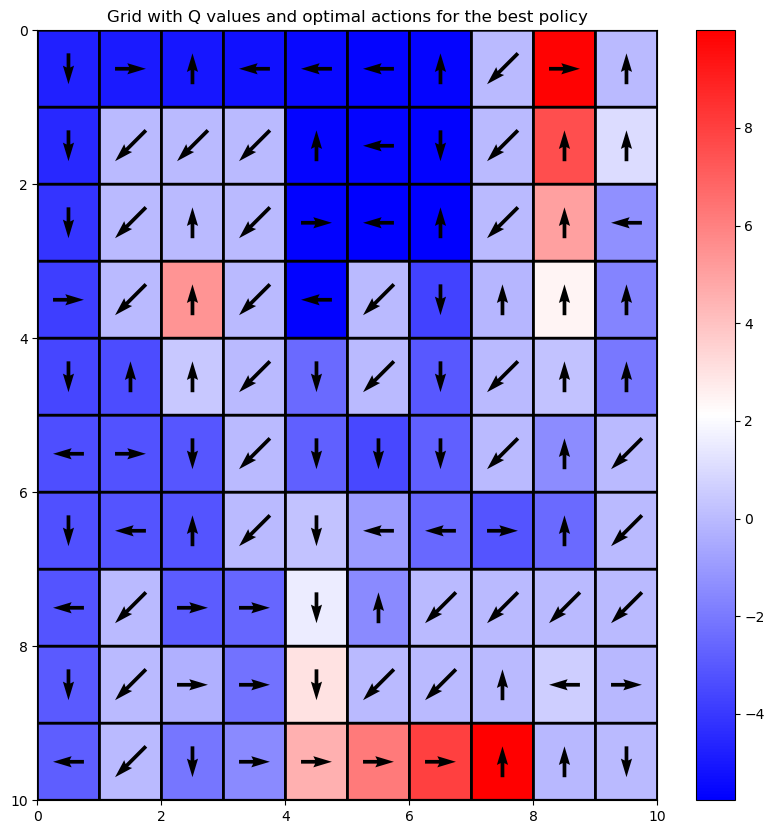

(<__main__.GridWorld object at 0x7f1bcaeb5510>, <function sarsa at 0x7f1be18b4fe0>)
9. Experiment with environment start_state: [3 6], wind: False, p = 0.7, algorithm: sarsa

Best hyperparameters for the above experiment:

 9) Alpha:0.37, Gamma:0.95, tau: 0.2, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:11<00:00, 875.59it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:11<00:00, 893.63it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:10<00:00, 916.29it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:10<00:00, 914.65it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:11<00:00, 906.33it/s]


Rewards:
 -19.8553
Steps:
 26.3609 



<Figure size 640x480 with 0 Axes>

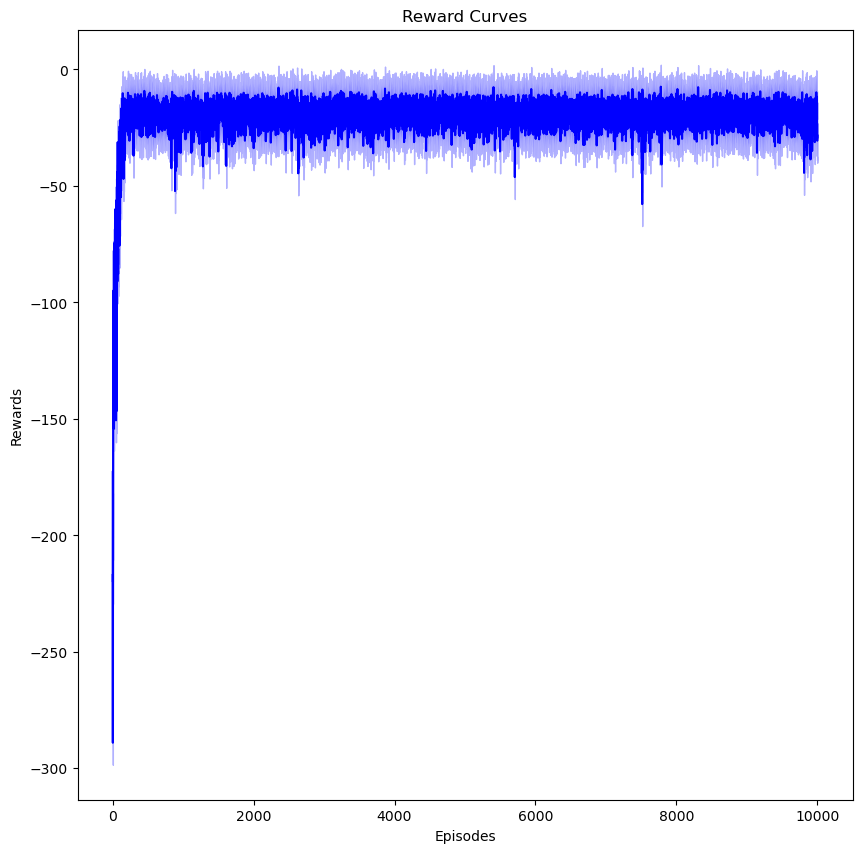

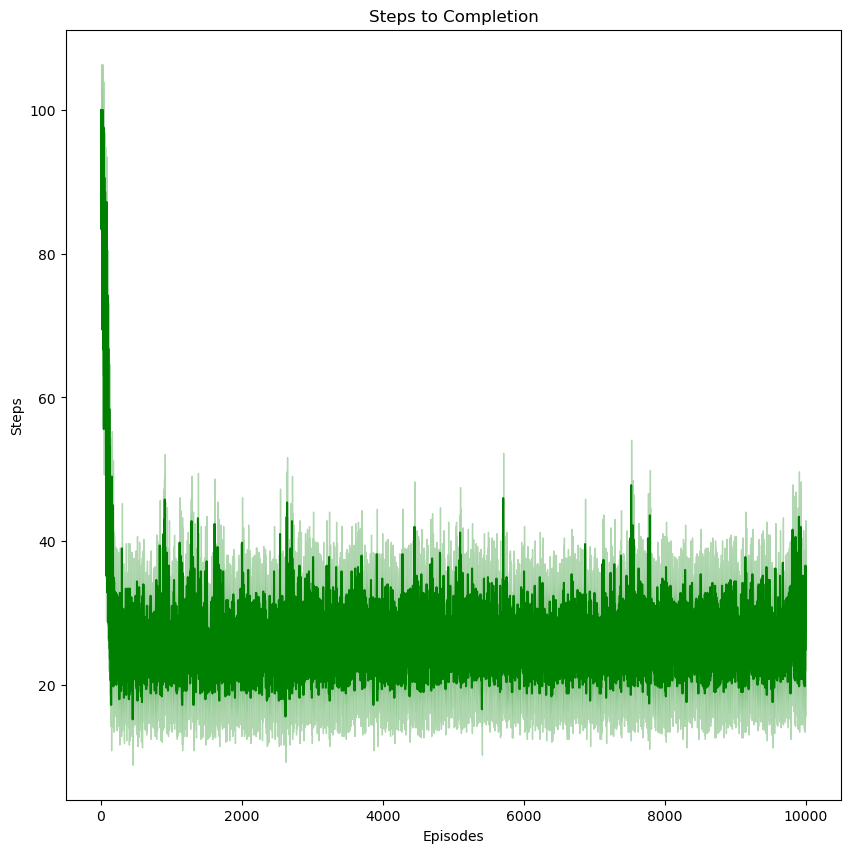

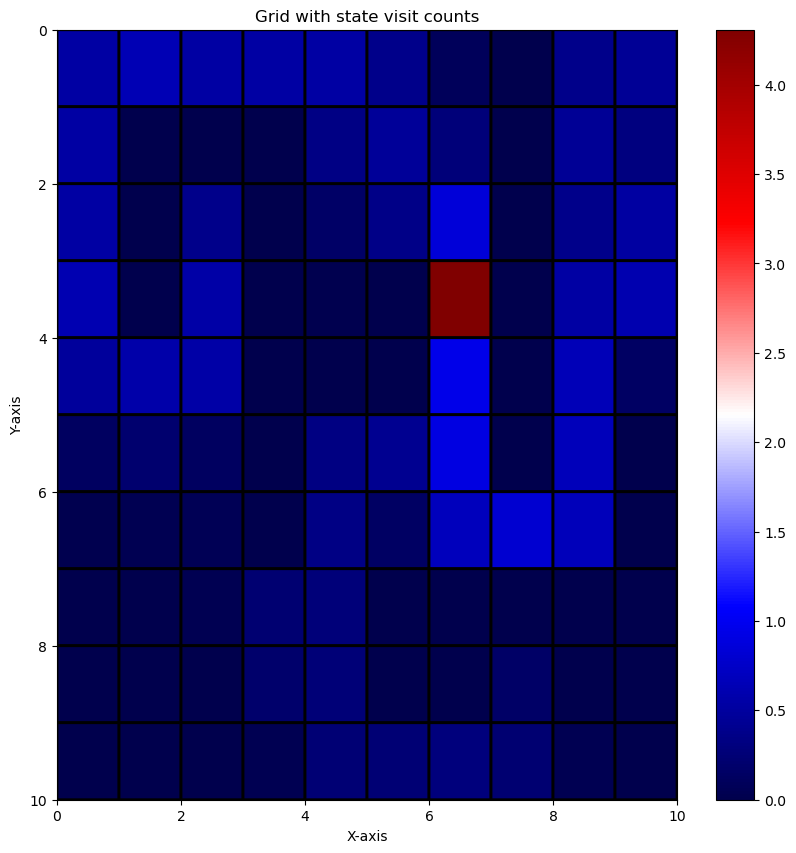

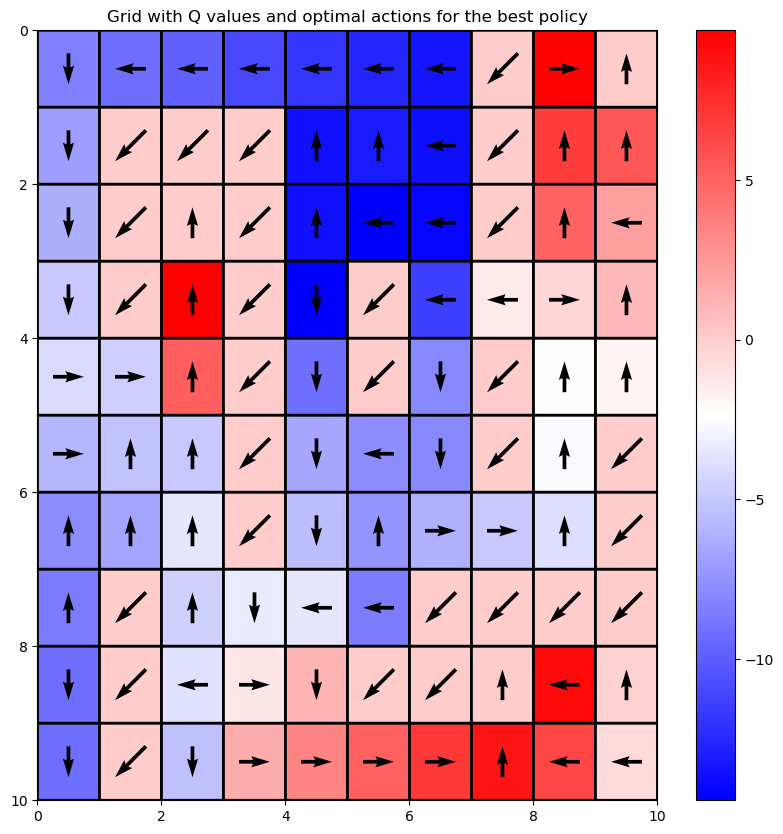

(<__main__.GridWorld object at 0x7f1bcaeb5510>, <function qlearning at 0x7f1bcb707a60>)
10. Experiment with environment start_state: [3 6], wind: False, p = 0.7, algorithm: qlearning

Best hyperparameters for the above experiment:

 10) Alpha:0.19, Gamma:0.95, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:11<00:00, 903.66it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:12<00:00, 816.73it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:17<00:00, 563.53it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:12<00:00, 795.95it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:11<00:00, 900.99it/s]


Rewards:
 -20.0823
Steps:
 25.45336 



<Figure size 640x480 with 0 Axes>

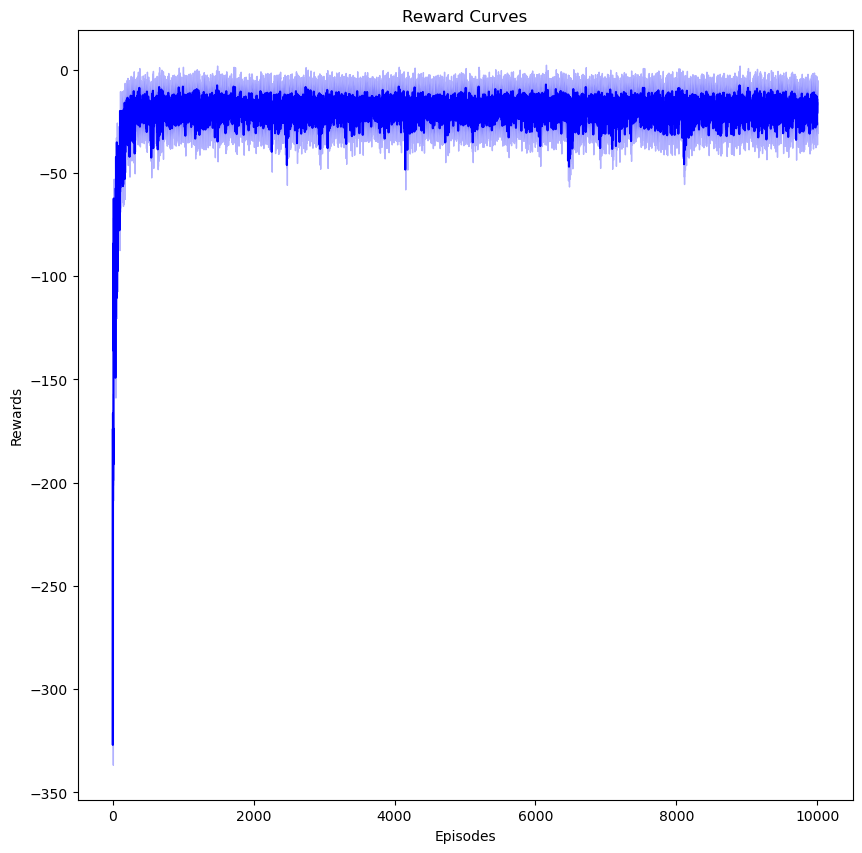

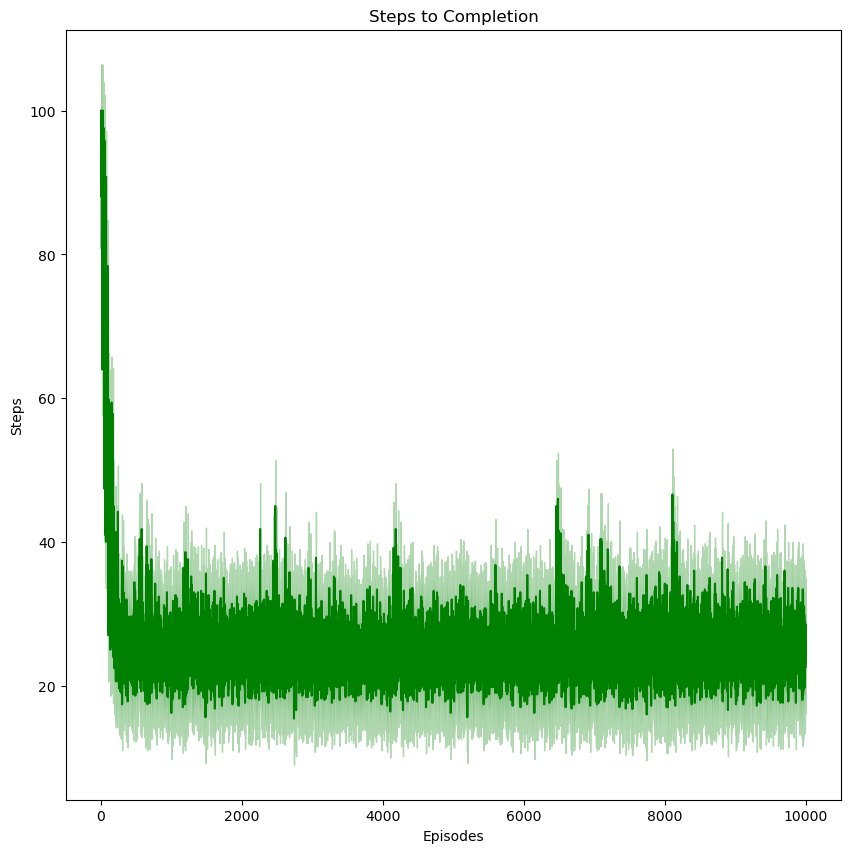

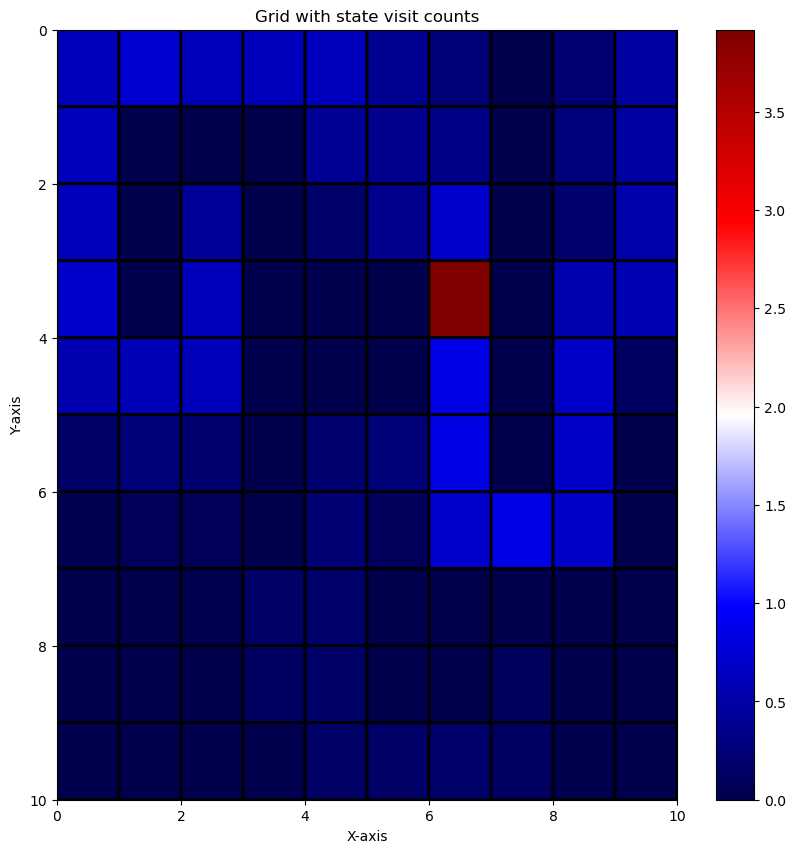

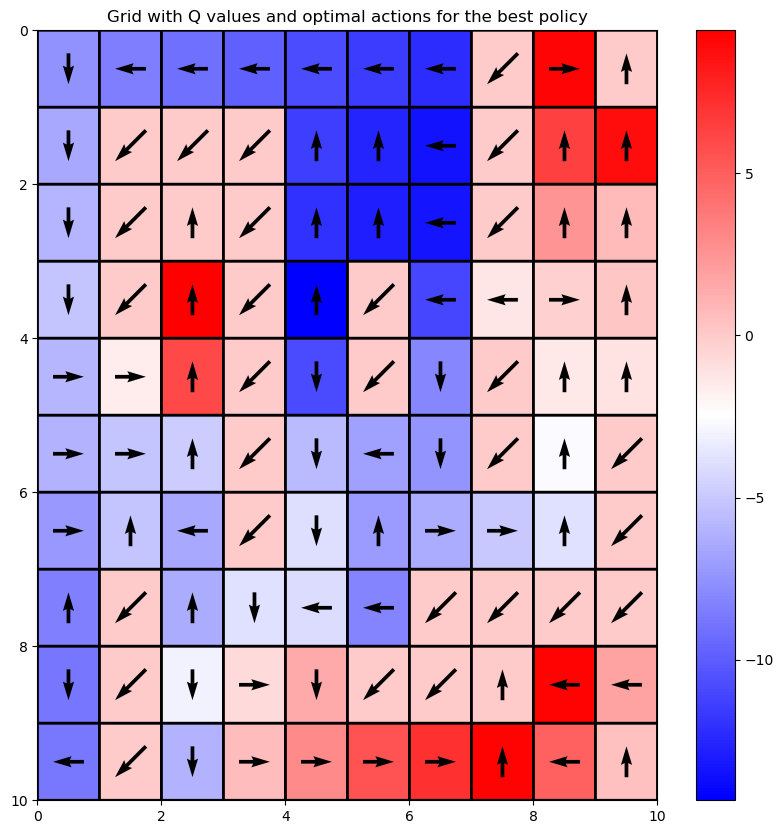

(<__main__.GridWorld object at 0x7f1bca542c50>, <function sarsa at 0x7f1be18b4fe0>)
11. Experiment with environment start_state: [3 6], wind: True, p = 1, algorithm: sarsa

Best hyperparameters for the above experiment:

 11) Alpha:0.37, Gamma:0.9, tau: 0.1, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:05<00:00, 1807.50it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:05<00:00, 1945.03it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:05<00:00, 1993.22it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:04<00:00, 2059.37it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:04<00:00, 2138.05it/s]


Rewards:
 -4.8789
Steps:
 10.75834 



<Figure size 640x480 with 0 Axes>

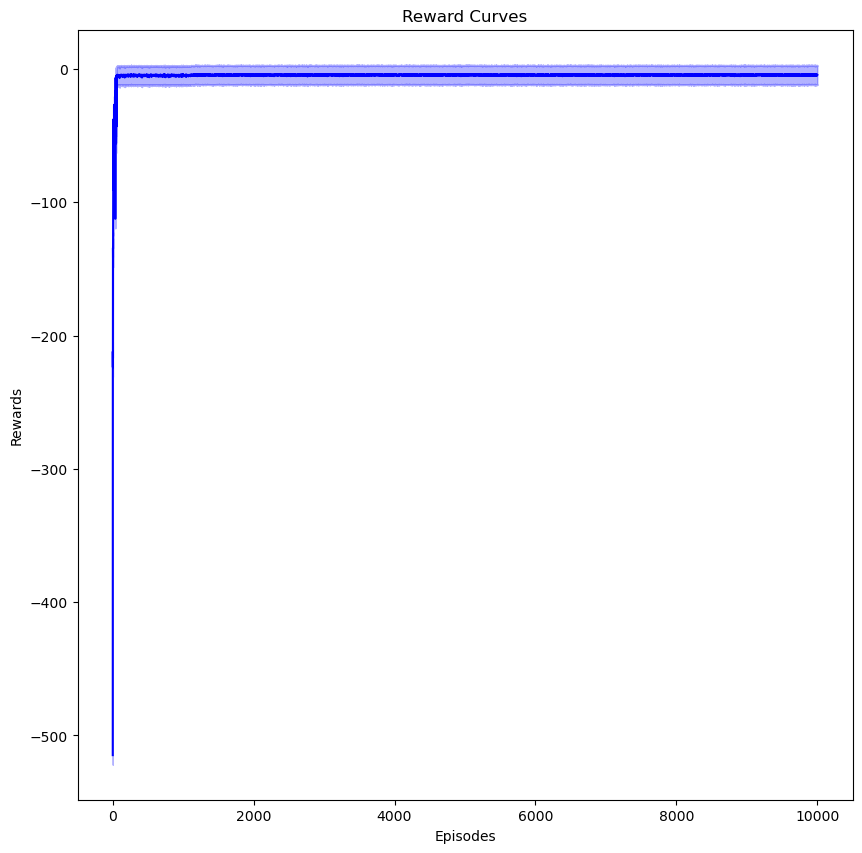

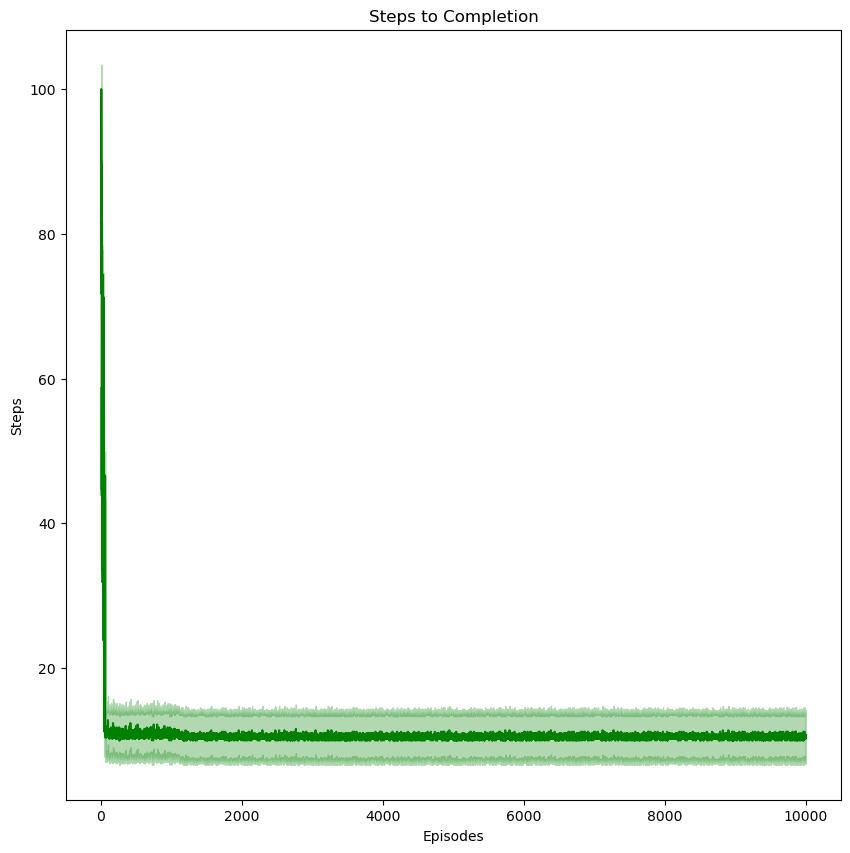

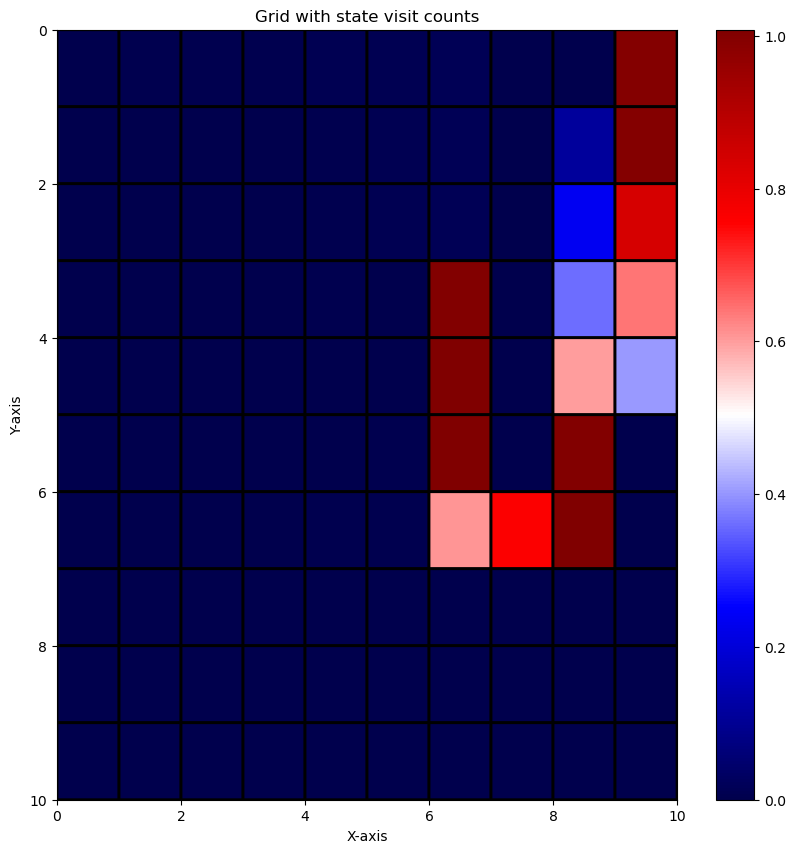

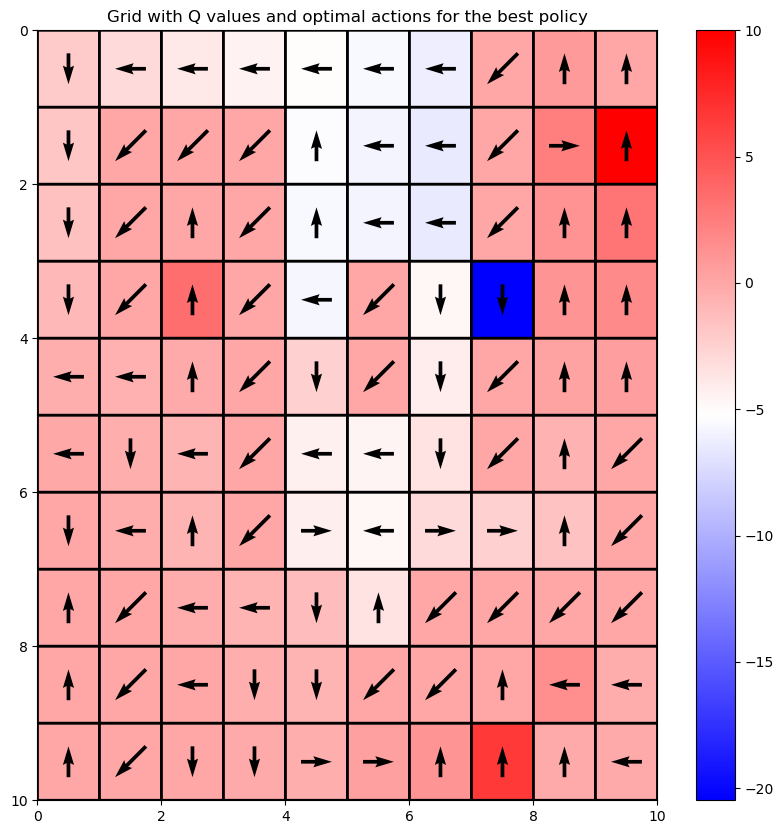

(<__main__.GridWorld object at 0x7f1bca542c50>, <function qlearning at 0x7f1bcb707a60>)
12. Experiment with environment start_state: [3 6], wind: True, p = 1, algorithm: qlearning

Best hyperparameters for the above experiment:

 12) Alpha:0.19, Gamma:0.9, tau: 0.2, policy:choose_action_softmax


Iteration: 1


100%|██████████| 10000/10000 [00:05<00:00, 1850.84it/s]


Iteration: 2


100%|██████████| 10000/10000 [00:05<00:00, 1924.70it/s]


Iteration: 3


100%|██████████| 10000/10000 [00:05<00:00, 1867.63it/s]


Iteration: 4


100%|██████████| 10000/10000 [00:05<00:00, 1671.79it/s]


Iteration: 5


100%|██████████| 10000/10000 [00:05<00:00, 1840.83it/s]


Rewards:
 -5.38368
Steps:
 11.2472 



<Figure size 640x480 with 0 Axes>

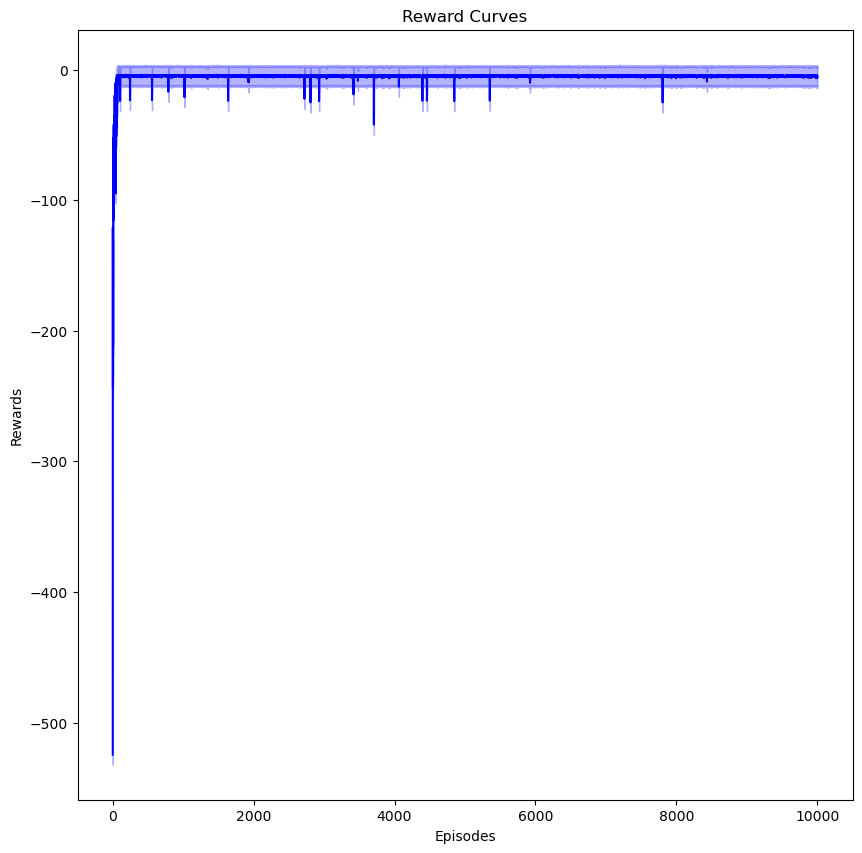

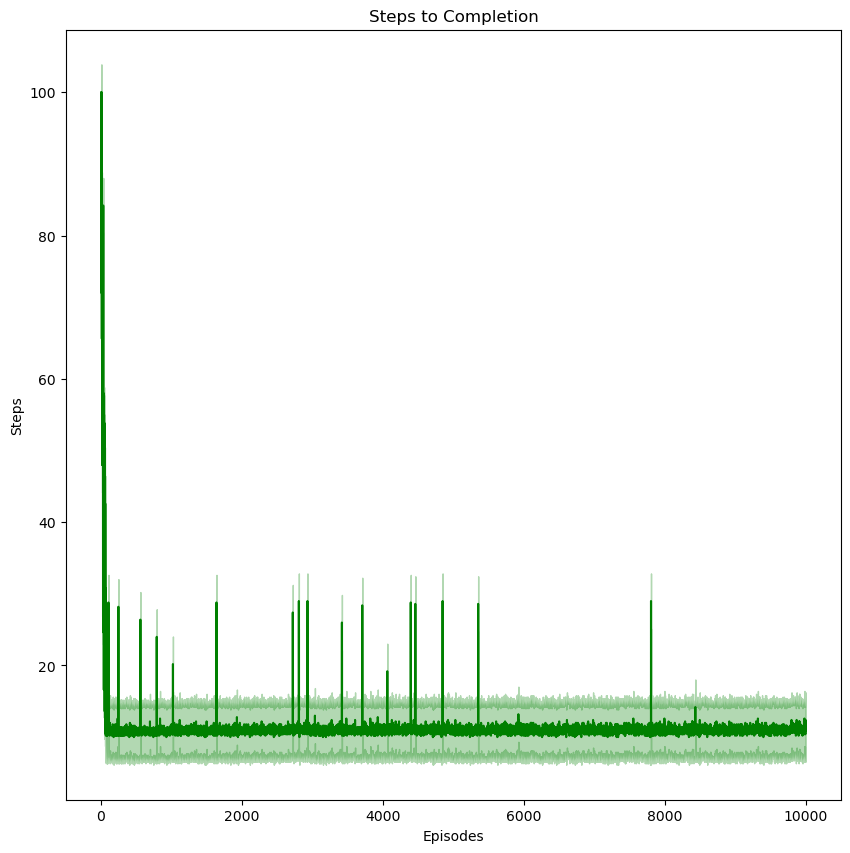

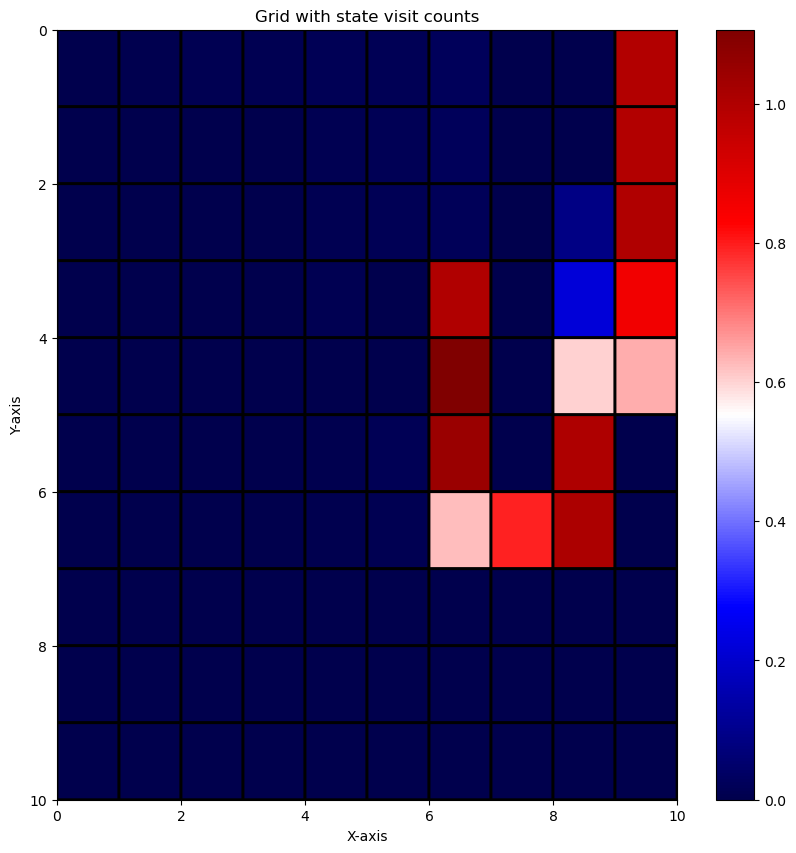

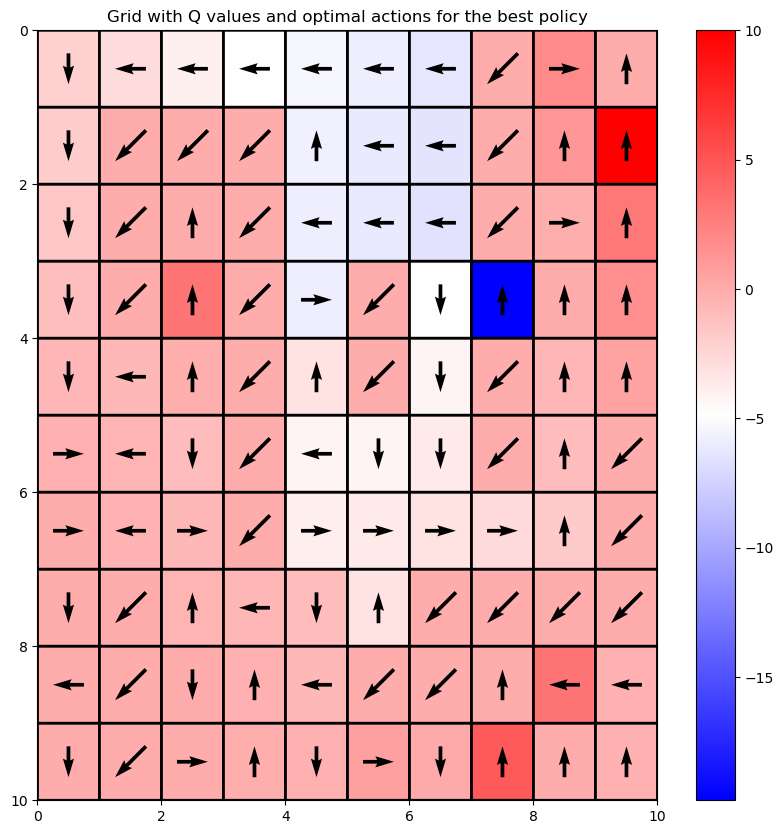

<Figure size 640x480 with 0 Axes>

In [704]:

for sno,(experiment, results) in enumerate(all_results.items(),start=1):
    os.makedirs(f'images/experiment_{sno}', exist_ok=True)
    print(experiment)
    env, algorithm = experiment
    best_hyperparameter_exp =  best_hyperparameters[(env, algorithm)]
    best_policy_exp = best_policy[(env, algorithm)] 
    policy_hp= None

    if(best_policy_exp.__name__ == "choose_action_epsilon"):
        policy_hp = "epsilon"
    else:
        policy_hp="tau"
    
    # Plot heatmap of Q values
    # print(best_hyperparameter_exp)
    print(f"{sno}. Experiment with environment start_state: {env.start_state[0]}, wind: {env.wind}, p = {env.p_good_trans}, algorithm: {algorithm.__name__}\n")
    print("Best hyperparameters for the above experiment:\n")
    print(f" {sno}) Alpha:{best_hyperparameter_exp[0]}, Gamma:{best_hyperparameter_exp[1]}, {policy_hp}: {best_hyperparameter_exp[2]}, policy:{best_policy_exp.__name__}")
    print("\n")    

    num_expts = 5
    reward_avgs, steps_avgs,state_avgs,Q_avgs = [], [], [],[]

    for i in range(num_expts):
        print("Iteration: %d"%(i+1))
        
        Q = np.zeros((env.num_states, env.num_actions))
        rg = np.random.RandomState(i)

        Q, rewards, steps,state_vist = algorithm(env, Q, gamma = best_hyperparameter_exp[1], alpha= best_hyperparameter_exp[0], plot_heat=False, choose_action=lambda Q, state: best_policy_exp(Q, state, best_hyperparameter_exp[2],rg))
        reward_avgs.append(rewards)
        steps_avgs.append(steps)
        state_avgs.append(state_vist)
        Q_avgs.append(Q)

    print("Rewards:\n",np.mean(reward_avgs))
    print("Steps:\n",np.mean(steps_avgs),"\n")


    steps_avgs =np.mean(steps_avgs,axis=0)
    reward_avgs =np.mean(reward_avgs,axis=0)
    state_avgs =np.mean(state_avgs,axis=0)
    Q_avgs =np.mean(Q_avgs,axis=0)




    
    visualize_rewards(reward_avgs,filename=f"images/experiment_{sno}/rewards.png")

    visualize_steps(steps_avgs,filename =f"images/experiment_{sno}/steps.png")

    visualize_steps_heatmap(np.mean(state_avgs, 0),filename =f"images/experiment_{sno}/state_visits.png")

    visulaize_Q_optimal(Q_avgs,filename=f"images/experiment_{sno}/Q_optimal.png")

    plt.tight_layout()


In [705]:
best_hyperparameters,best_policy

({(<__main__.GridWorld at 0x7f1bcb661f50>,
   <function __main__.sarsa(env, Q, gamma=0.9, alpha=0.4, plot_heat=False, choose_action=<function choose_action_softmax at 0x7f1be18b6ac0>)>): (0.9099999999999999,
   0.95,
   0.2),
  (<__main__.GridWorld at 0x7f1bcb661f50>,
   <function __main__.qlearning(env, Q, gamma=0.9, alpha=0.4, plot_heat=False, choose_action=<function choose_action_softmax at 0x7f1be18b6ac0>)>): (0.28,
   0.95,
   0.1),
  (<__main__.GridWorld at 0x7f1bcae35f50>,
   <function __main__.sarsa(env, Q, gamma=0.9, alpha=0.4, plot_heat=False, choose_action=<function choose_action_softmax at 0x7f1be18b6ac0>)>): (0.28,
   0.95,
   0.1),
  (<__main__.GridWorld at 0x7f1bcae35f50>,
   <function __main__.qlearning(env, Q, gamma=0.9, alpha=0.4, plot_heat=False, choose_action=<function choose_action_softmax at 0x7f1be18b6ac0>)>): (0.37,
   0.95,
   0.1),
  (<__main__.GridWorld at 0x7f1bcbac0d90>,
   <function __main__.sarsa(env, Q, gamma=0.9, alpha=0.4, plot_heat=False, choose_actio